# Exmamining the TCR Beta Chain Repertoire Through Time

This notebook is the second notebook looking at a dataset (TCRB Time Course) from [Adaptive Biotechnology's](http://www.adaptivebiotech.com) [ImmuneAccess](https://clients.adaptivebiotech.com/login) platform. I have discussed publishing on this dataset with Ryan Emerson (remerson@adaptivebiotech.com) who said that we can publish on the dataset and that he would be open to discussing a collaboration.

From my first notebook, the primary findings was the discovery of a persistant TCR repertoire in any given individual: a subset of the TCR repertoire that persisted over all time points that consituted a larger-than-expected fraction of the TCR repertoire.

Questions:

1. How do TCRs covary through time? What is the cooccurence network? Do clonotypes of the same TCR epitope track in time?
2. How can one most easily detect the durable TCR repertoire? Are regular samples needed, or do fewer samples farther apart capture that diversity?
3. How deeply does one have to sequence each sample to detect the persistant TCR repertoire? How robust is this signal to changes in the sequencing or the number of time points?
4. How does the durable TCR repertoire overlap with public TCRs over a larger number of samples pooled from multiple studies?
5. What are the dynamics of TCRs that arise during the time course and persist?
6. Do some TCRs increase or decrease in abundance monotonically?
7. How does the persistant TCR repertoire overlap with naive or memory T cell populations?

In [ ]:
#ONLY IF USING A SERVER (SET DISPLAY SETTINGS)
import matplotlib
matplotlib.use('AGG')

In [19]:
import matplotlib.pyplot as plt, pandas as pd, numpy as np
import seaborn as sns, skbio.diversity as div, random, itertools, os
import scipy.stats as stats
import datetime, skbio.stats.distance as distance, scipy.cluster.hierarchy as hc
import skbio.diversity.alpha as alpha
from collections import Counter, defaultdict
from datetime import datetime
from scipy.stats import spearmanr, pearsonr
from sklearn import manifold
from skbio.stats import subsample_counts
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [68]:
def jensen_shannon(x, y):
      """
      calculates the jensen-shannon divergence between two vectors: x and y
      @author: jonathanfriedman
      
      Can accept lists, pandas series
      """
      x = np.array(x)
      y = np.array(y)
      dist_1 = x * np.log2(2 * x/(x + y))
      dist_2 = y * np.log2(2 * y/(x + y))
      dist_1[np.isnan(dist_1)] = 0
      dist_2[np.isnan(dist_2)] = 0
      dist_final = 0.5 * np.sum(dist_1 + dist_2)    
      return dist_final

In [ ]:
def plot_freq_comparison(x_series, y_series, log=True, spearman=True, return_axes=True):
    """
    Takes two series, which are assumed to be the same type of values and 
    plot the two against each other.
    
    The two series either must have identical indexes OR have indexes that
    are related, and thus comparison of each index is valid
    
    Log will plot both axes using a log scale
    Spearman will annotate the figure with the # of shared elements, spearman rho, and p val
    Return axes will return the axes object
    """
    tmp_table = pd.concat([x_series, y_series], axis=1)
    tmp_table = tmp_table.fillna(0) #fill missing values with zero
    fig = plt.figure()
    plt.scatter(tmp_table.iloc[:, 0].values, tmp_table.iloc[:, 1].values,
                facecolors='none', edgecolors='grey')
    plot_max = max([x_series.max(), y_series.max()])
    linthresh = min([x_series.min(), y_series.min()])
    if log:
        plt.xscale('symlog', linthreshx=linthresh)
        plt.yscale('symlog', linthreshy=linthresh)
    plt.xlim(0, plot_max)
    plt.ylim(0, plot_max)
    sns.despine()
    
    #calculate spearman correlation and report
    if spearman:
        tmp_table = tmp_table[~(tmp_table == 0).any(axis=1)] #keep only shared tcrs
        rho, pval = stats.spearmanr(tmp_table.iloc[:, 0].values,
                                    tmp_table.iloc[:, 1].values)
        plt.annotate('shared tcrs = {0}, rs = {1:.5f}, p = {2:.5f}'.format(len(tmp_table.index), rho, pval), 
                     xy=(1,0.05), xycoords='axes fraction', 
                     horizontalalignment='right', verticalalignment='bottom')
    if return_axes:
        return fig

In [ ]:
def clean_adaptive_v1(adaptive_table, file_link=False, output=False):
    """
    Cleans an adpative table, returning a table
    1. Removes rows without an aa seq
    2. With a stop codon in the aa seq
    3. With any error in aa seq.
    4. If the V or J region is unresolved

    It also subsets the columns to be written
    """
    if file_link:
        adaptive_table = pd.read_csv(adaptive_table, sep='\t')
  
    #drop lines without an epitope
    adaptive_table = adaptive_table.dropna(subset=['aminoAcid']) 
    #drop lines with stop codon
    adaptive_table = adaptive_table[adaptive_table.aminoAcid.str.contains("\*") == False] 
    #drop lines with 'unresolved'
    adaptive_table = adaptive_table[adaptive_table.aminoAcid.str.contains(r'[a-z]') == False] 
  
    #take out lines with unresolved v or j regions
    adaptive_table = adaptive_table.drop(adaptive_table[adaptive_table.vMaxResolved == 'unresolved'].index) 
    adaptive_table = adaptive_table.drop(adaptive_table[adaptive_table.jMaxResolved == 'unresolved'].index)
    adaptive_table = adaptive_table[['nucleotide', 'aminoAcid', 
                                     'count (templates/reads)', 
                                     'frequencyCount (%)', 'vMaxResolved', 
                                     'dMaxResolved', 'jMaxResolved', 'vDeletion',
                                     'n1Insertion', 'd5Deletion', 'd3Deletion', 
                                     'n2Insertion', 'jDeletion']]
  
    if output:
        adaptive_table.to_csv(output, sep='\t', index=False)
  
    return adaptive_table

In [23]:
def plot_ind_freq(frequency_list, log=False, descending=True):
    """
    For a given list of frequencies, plots each frequency in order. This script
    helps visualize the decay of frequencies of things like TCRs
    """
    if descending:
        frequency_list = sorted(frequency_list, reverse=True)
    else:
        frequency_list = sorted(frequency_list)
    x_val = range(len(frequency_list))
    plt.scatter(x_val, frequency_list, facecolors='none', edgecolors='grey')
    if log:
        plt.yscale('log')

In [ ]:
#Read in metadata
metadata = pd.read_csv('/Users/ndchu/Documents/TCR_fmt/tcrb_timecourse/tcrb_timecourse_metadata.txt',
                     sep='\t')
#get copy with sample_short as the index
metadata_sample = metadata.set_index('sample_short')

In [24]:
#Read in full time series data for Subject01
sub1_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject01_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [5]:
#get only PBMCs from Subject01
sub1_pbmc_samples = metadata[(metadata['individual'] == 'subject01') & (metadata['cells'] == 'PBMC')]['sample_short']
sub1_pbmc_timecourse = sub1_timecourse[(sub1_timecourse['sample'].isin(sub1_pbmc_samples))]

In [10]:
#get only timecourse data from the persistent TCR epitope repertoire
sub1_pers_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject01_persistantTCRepi_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [3]:
#Read in time series data for Subject02
sub2_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject02_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [ ]:
#Read in time series data for Subject03
sub3_timecourse = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/subject03_timecourse.tsv.gz', 
                                           sep='\t', compression='gzip')

In [2]:
#Read in occurence data for all TCR epitopes
epitope_occurence = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/tcr_epitopes_occurence_all.tsv.gz',
                                sep='\t', compression='gzip')

In [4]:
#Read in occurence data for TCR epitopes in Subject01
sub1_epi_occurence = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/tcr_epitopes_occurence_sub1.tsv.gz',
                                sep='\t', compression='gzip')

### Adding nucleotide and amino acid information back to timecourse data

In [ ]:
#read in data from /home/ubuntu/users/ndchu/tcr/tcrb_timecourse
timecourse = pd.read_csv('all_subjects_timecourse.tsv.gz',
                         sep='\t', compression='gzip')
#metadata
metadata = pd.read_csv('tcrb_timecourse_metadata.txt', sep='\t')

In [ ]:
cl_files = os.listdir('./clean_files')
tables = []

#dictionary for sample_file -> sample
cell_dict = metadata.set_index('cl_files').to_dict()['sample_short']

for file in cl_files:
    #read in file
    tmp_cl = pd.read_csv('./clean_files/' + file, sep='\t', compression='gzip')
    tmp_cl = tmp_cl.rename(columns={'count (templates/reads)': 'count',
                                    'frequencyCount (%)': 'freq',
                                    'vMaxResolved': 'v',
                                    'dMaxResolved': 'd',
                                    'jMaxResolved': 'j'}).reset_index(drop=True)
    
    #get relevant sample
    sample = cell_dict[file]
    
    #subset timecourse table
    tmp_time = timecourse.loc[timecourse['sample'] == sample].reset_index(drop=True)
    
    #check that the tables are matching
    if tmp_cl[['count', 'v', 'j']].equals(tmp_time[['count', 'v', 'j']]):
        new_table = pd.concat([tmp_time, tmp_cl[['nucleotide', 'aminoAcid']]], axis=1)
        tables.append(new_table)
    else:
        print("There is a matching error with file " + file)

#concatenate all of the resulting tables
final_table = pd.concat(tables).reset_index(drop=True)

#write table to a file
final_table.to_csv('all_subjects_timecourse_w_nuc_aa.tsv.gz', sep='\t', index=False,
                  compression='gzip')

## Covariance of TCR clonotypes for the same TCR epitope

If TCR clonotypes that encode the same TCR epitope are under the same selective pressure, we expect their abundances through time to track each other. For example, for those TCR epitopes that arise in the middle of the time series, do all consituent clonotypes arise together and track each other? Is there a time lag between the arrival of clonotypes of the same epitope?

In the persistant TCR repertoire:

1. What is the distribution of covariance between random TCR epitopes and clonotypes?
2. What is the coavariance of TCR clonotypes from the same epitope?

In [7]:
#First let's look at the covariance of all pairs of persistent TCR epitopes
sub1_pers_tcrs = epitope_occurence.loc[epitope_occurence['num_occ_in_sub1_pbmc'] == 8]['tcr_epitope'].values

#get persistent time course table
sub1_pers_timecourse = sub1_pbmc_timecourse[(sub1_pbmc_timecourse['tcr_epitope'].isin(sub1_pers_tcrs))]

In [28]:
#first we need to sum each TCR over it's clonotypes for each time point
sub1_pers_sumepi = sub1_pers_timecourse.groupby(['tcr_epitope', 'sample']).sum().reset_index()

#now make a dictionary, where the key is the TCR epitope and the value is a numpy array
#of frequencies, in order of time points
time_arrays = sub1_pers_sumepi.groupby('tcr_epitope').apply(lambda x: x.sort_values('sample')['freq'].values)

In [56]:
spearman_allpw = [] #format (rho, p-value)
pearson_allpw = [] #format (Pearson coefficient, 2-tailed p-value)
#for each pairwise combination (not product, spearman/pearson are symmetrical), get correlation
#For ease of computing, option to subsample the combinations
tcr_pairs = itertools.combinations(time_arrays.index.values, 2)
tcr_pairs = random.sample(tuple(tcr_pairs), 100000)
for tcr1, tcr2 in tcr_pairs:
    spearman_allpw.append(stats.spearmanr(time_arrays[tcr1], time_arrays[tcr2]))
    pearson_allpw.append(stats.pearsonr(time_arrays[tcr1], time_arrays[tcr2]))

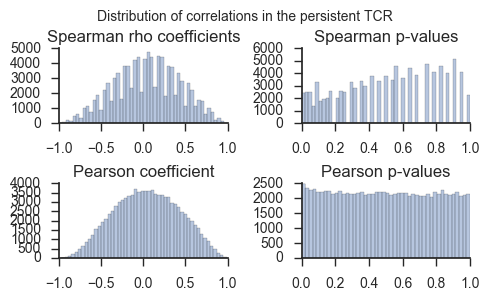

In [59]:
#plot the distribution of both correlation coefficients and p-values for the 100000 subsample
fig = plt.figure(figsize=(5, 3))
plt.suptitle('Distribution of correlations in the persistent TCR')

ax1 = fig.add_subplot(2,2,1)
sns.distplot([x[0] for x in spearman_allpw], kde=False)
plt.title('Spearman rho coefficients')

ax2 = fig.add_subplot(2,2,2)
sns.distplot([x[1] for x in spearman_allpw], kde=False)
plt.title('Spearman p-values')

ax3 = fig.add_subplot(2,2,3)
sns.distplot([x[0] for x in pearson_allpw], kde=False)
plt.title('Pearson coefficient')

ax4 = fig.add_subplot(2,2,4)
sns.distplot([x[1] for x in pearson_allpw], kde=False)
plt.title('Pearson p-values')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
sns.despine()

So the random TCR pairs do look pretty random, so that's good. We can also do a similar analysis for TCR clonotypes

In [30]:
def conform_array(df, output_col, index_col, index_values, fill=np.nan):
    """
    This script takes a dataframe, and returns an array of values from the column
    output_col. The shape of the array will be of length len(index_values), and the
    order of the values will be based on the matched order of index_values and
    index_col. If index_col is missing values present in index_values, then those
    array positions will be filled with the value of "fill".
    """
    series = pd.concat([pd.Series(index=index_values), df.set_index(index_col)[output_col]], axis=1)
    if fill != np.nan:
        series = series.fillna(fill)
    return series[output_col].values

In [9]:
sample_list = ['s1_110316_PBMC',
               's1_110415_PBMC',
               's1_110512_PBMC',
               's1_110609_PBMC',
               's1_110819_PBMC',
               's1_110915_PBMC',
               's1_111014_PBMC',
               's1_120320_PBMC']

In [28]:
#Look at all covariation of pw clonotypes
#not all clonotypes are present in all timepoints, so we have to account for this
#We'll count them as zeros, since we are looking at correlations, not differential abundance
time_arrays = sub1_pers_timecourse.groupby('tcr_clonotype').apply(conform_array,
                                                                 output_col='freq',
                                                                 index_col='sample',
                                                                 index_values=sample_list,
                                                                 fill=0)

In [30]:
spearman_allpw = [] #format (rho, p-value)
pearson_allpw = [] #format (Pearson coefficient, 2-tailed p-value)
#for each pairwise combination (not product, spearman/pearson are symmetrical), get correlation
#For ease of computing, option to subsample the combinations
tcr_pairs = itertools.combinations(time_arrays.index.values, 2)
tcr_pairs = random.sample(tuple(tcr_pairs), 100000)
for tcr1, tcr2 in tcr_pairs:
    spearman_allpw.append(stats.spearmanr(time_arrays[tcr1], time_arrays[tcr2]))
    pearson_allpw.append(stats.pearsonr(time_arrays[tcr1], time_arrays[tcr2]))

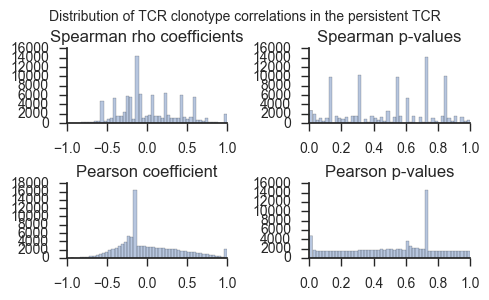

In [31]:
#plot the distribution of both correlation coefficients and p-values for the 100000 subsample
#FOR TCR CLONOTYPES, but using all clonotype that are in the persistent TCR, which is
#defined by TCR epitopes
fig = plt.figure(figsize=(5, 3))
plt.suptitle('Distribution of TCR clonotype correlations in the persistent TCR')

ax1 = fig.add_subplot(2,2,1)
sns.distplot([x[0] for x in spearman_allpw], kde=False)
plt.title('Spearman rho coefficients')

ax2 = fig.add_subplot(2,2,2)
sns.distplot([x[1] for x in spearman_allpw], kde=False)
plt.title('Spearman p-values')

ax3 = fig.add_subplot(2,2,3)
sns.distplot([x[0] for x in pearson_allpw], kde=False)
plt.title('Pearson coefficient')

ax4 = fig.add_subplot(2,2,4)
sns.distplot([x[1] for x in pearson_allpw], kde=False)
plt.title('Pearson p-values')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
sns.despine()

Well, this picture for clonotypes looks a little weirder, but that is proably expected given that many TCR clonotypes are at pretty low frequency and thus a lot of these arrays were largely empty.

Let's try to identify TCR epitopes that have multiple TCR clonotypes present in all or most samples.

In [10]:
#first get the number of samples for TCR epitope and clonotype combination
tmp = sub1_pers_timecourse.groupby(['tcr_epitope', 'tcr_clonotype']).size().reset_index()
tmp = tmp.loc[tmp[0] == 8] #get only clonotypes in all 8 samples
#get how many complete clonotypes per TCR epitope
tmp = tmp.groupby('tcr_epitope').size().reset_index()
tmp = tmp.loc[tmp[0] > 1] #get multiple complete clonotypes per epitope
tmp = tmp.rename(columns={0: 'number_complete_TCR_clonotypes'})

#67 TCR epitopes with multiple clonotypes over all time points
tcre_multiple_cln = tmp.rename(columns={0: 'number_complete_TCR_clonotypes'}).reset_index(drop=True)

In [37]:
#let's look at the data from a single clone, tcr_20950
tmp = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_epitope'] == 'tcr_20950']

#get only tcr_clonotypes that occur in at least 2 samples
tmp_list = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 1].index.tolist()
tmp = tmp.loc[tmp['tcr_clonotype'].isin(tmp_list)]

tmp['date'] = tmp['sample'].apply(lambda x: metadata.set_index('sample_short').to_dict()['time'][x])
tmp['date1'] = tmp['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date().toordinal())

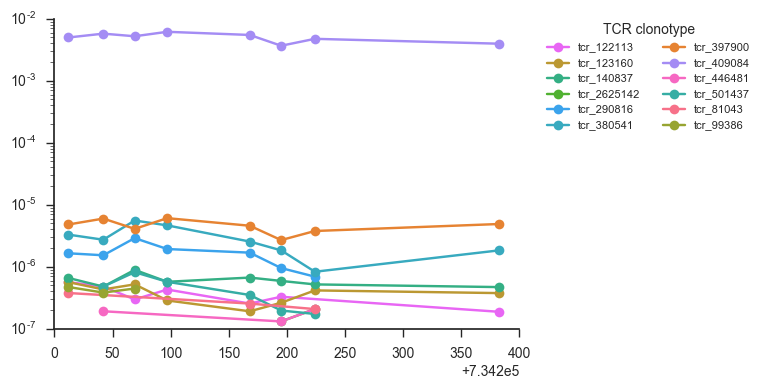

In [52]:
#plot this times series for tcr_epitope 20950
clrs = sns.color_palette("husl", 12) #make a colormap object
random.shuffle(clrs) #shuffle the colors

counter = 0
for clone, sub_df in tmp.sort_values(['tcr_clonotype', 'date1']).groupby('tcr_clonotype'):
    plt.plot(sub_df['date1'], sub_df['freq'], '-o', label=clone, color=clrs[counter])
    counter += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='TCR clonotype',
          fontsize=8, ncol=2)
plt.yscale('log')
sns.despine()

In [32]:
#what is the correlation between these clonotypes?
#First get all of the largely complete TCR clonotypes
tcr_comp = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 6].index.tolist()

#get only these TCR clonotypes
tcr_20950_df = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_clonotype'].isin(tcr_comp)]

#make time arrays for each clonotype
time_arrays_20950 = tcr_20950_df.groupby('tcr_clonotype').apply(conform_array,
                                                                output_col='freq',
                                                                index_col='sample',
                                                                index_values=sample_list,
                                                                fill=0)

#get correlation values
spearman_pw = {} #format key-(tcr1, tcr2) value-(rho, p-value)
pearson_pw = {} #format key-(tcr1, tcr2) value-(Pearson coefficient, 2-tailed p-value)
tcr_pairs = itertools.combinations(time_arrays_20950.index.values, 2)
for tcr1, tcr2 in tcr_pairs:
    spearman_pw[(tcr1, tcr2)] = stats.spearmanr(time_arrays_20950[tcr1], time_arrays_20950[tcr2])
    pearson_pw[(tcr1, tcr2)] = stats.pearsonr(time_arrays_20950[tcr1], time_arrays_20950[tcr2])

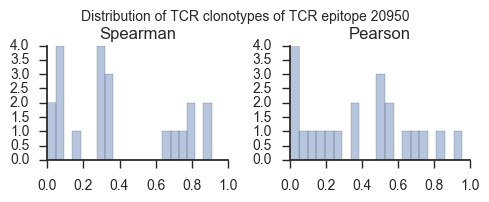

In [59]:
#plot the pvalues
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Distribution of TCR clonotypes of TCR epitope 20950')

ax1 = fig.add_subplot(1,2,1)
spearman_pvals = [x[1] for x in spearman_pw.values()]
sns.distplot(spearman_pvals, kde=False, bins=20)
plt.title("Spearman")

ax2 = fig.add_subplot(1,2,2)
pearson_pvals = [x[1] for x in pearson_pw.values()]
sns.distplot(pearson_pvals, kde=False, bins=20)
plt.title("Pearson")

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.8)

The most obvious feature of this data is a single tcr_clonotype that numericall dominates the rest of the TCRs. This likely but not necessarily suggests that the lower abundance clones might be sequencing or PCR errors of the same prevalent clone.

The dynamics of these individual TCRs do not appear to necessarily track the overall abundance of this TCR epitope, which is almost entirely driven by the abundance of 409084. There doesn't seem to be any tight or significant correlation between the various TCR clonotypes, but maybe this would be more apparant in TCRs that arise part way through the time series. The absense of correlation might suggest that the lower abundance TCRs are not contamination/errors, since we would expect those to correlate pretty well.

Are there other TCR epitopes that seems to have multiple equally prevalent TCR clonotypes?

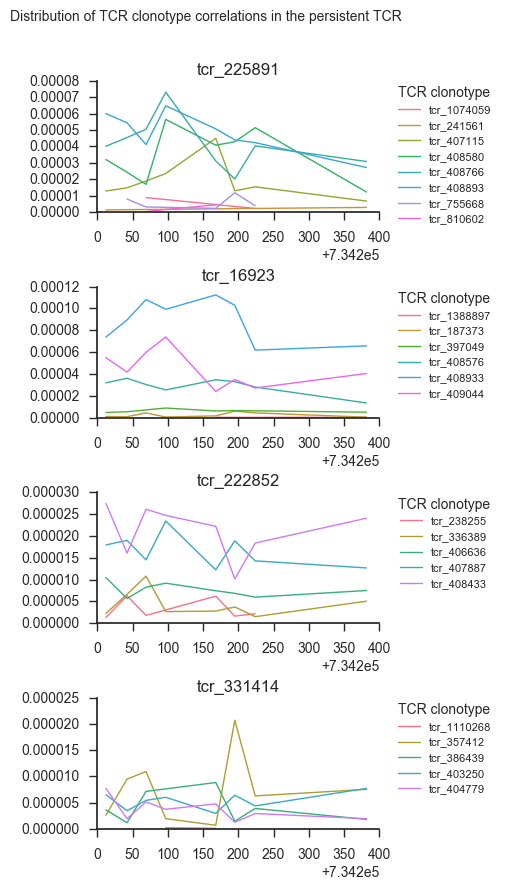

In [74]:
#plot the 4 other TCR epitopes with more than 2 TCR clonotypes in all samples
top_tcre_multiple_cln = ['tcr_225891', 'tcr_16923', 'tcr_222852', 'tcr_331414']

fig = plt.figure(figsize=(4, 9))
plt.suptitle('Distribution of TCR clonotype correlations in the persistent TCR')

plt_count = 1
for tcre in top_tcre_multiple_cln:
    tmp = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_epitope'] == tcre]
    #get only tcr_clonotypes that occur in at least 2 samples
    tmp_list = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 1].index.tolist()
    tmp = tmp.loc[tmp['tcr_clonotype'].isin(tmp_list)]

    tmp['date'] = tmp['sample'].apply(lambda x: metadata.set_index('sample_short').to_dict()['time'][x])
    tmp['date1'] = tmp['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date().toordinal())
    
    ax = fig.add_subplot(4,1,plt_count)
    clrs = sns.color_palette("husl", len(tmp_list)) #organize colors

    counter = 0
    for clone, sub_df in tmp.sort_values(['tcr_clonotype', 'date1']).groupby('tcr_clonotype'):
        plt.plot(sub_df['date1'], sub_df['freq'], '-o', label=clone, color=clrs[counter],
                markersize=0, linewidth=1)
        counter += 1

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='TCR clonotype',
          fontsize=8)
    plt.title(tcre)
    
    plt_count += 1

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So we see that a number of epitopes don't have a dominant clonotype. Most of these TCR clonotypes have comparable abundances in the 10-6 to 10-5 range. Some of these TCRs appear to be even anti-correlated, which certainly doesn't suggest that they are merely errors.

Let's look at the correlations we get here.

In [84]:
#look at correlations of TCR clonotypes in the above plotted subsets
top_tcre_multiple_cln = ['tcr_225891', 'tcr_16923', 'tcr_222852', 'tcr_331414']

sprmn_top_tcre = {}
prsn_top_tcre = {}

for tcre in top_tcre_multiple_cln:
    tmp = sub1_pers_timecourse.loc[sub1_pers_timecourse['tcr_epitope'] == tcre]
    #get only tcr_clonotypes that occur in at least 2 samples
    tmp_list = (tmp.groupby(['tcr_clonotype']).size())[tmp.groupby(['tcr_clonotype']).size() > 1].index.tolist()
    tmp = tmp.loc[tmp['tcr_clonotype'].isin(tmp_list)]
    
    time_arrays_tmp = tmp.groupby('tcr_clonotype').apply(conform_array,
                                                         output_col='freq',
                                                         index_col='sample',
                                                         index_values=sample_list,
                                                         fill=0)
    #nest dictionary to organize results
    sprmn_top_tcre[tcre] = {}
    prsn_top_tcre[tcre] = {}
    
    tcr_pairs = itertools.combinations(time_arrays_tmp.index.values, 2)
    for tcr1, tcr2 in tcr_pairs:
        sprmn_top_tcre[tcre][(tcr1, tcr2)] = stats.spearmanr(time_arrays_tmp[tcr1], time_arrays_tmp[tcr2])
        prsn_top_tcre[tcre][(tcr1, tcr2)] = stats.pearsonr(time_arrays_tmp[tcr1], time_arrays_tmp[tcr2])

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


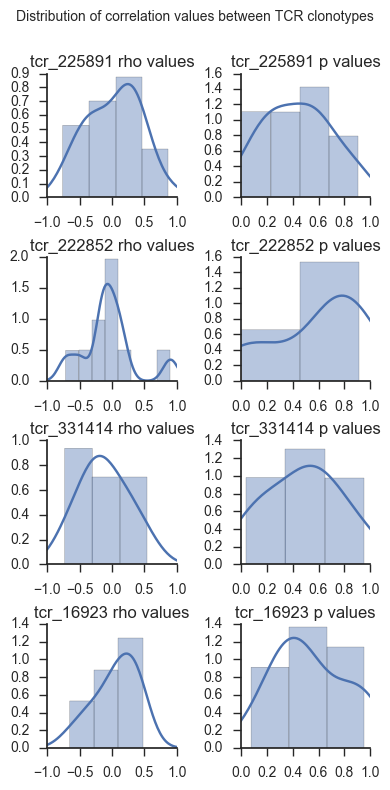

In [88]:
#plot correlation coefficients and pvalues for each TCR epitope
fig = plt.figure(figsize=(4, 8))
plt.suptitle('Distribution of correlation values between TCR clonotypes')

plt_count = 1
for tcre in sprmn_top_tcre:
    ax = fig.add_subplot(4,2,plt_count)
    sns.distplot([x[0] for x in sprmn_top_tcre[tcre].values()]) #coefficients
    plt.title(tcre + " rho values")
    plt.xlim(-1, 1)
    plt_count += 1
    
    ax = fig.add_subplot(4,2,plt_count)
    sns.distplot([x[1] for x in sprmn_top_tcre[tcre].values()]) #pvals
    plt.title(tcre + " p values")
    plt.xlim(0, 1)
    plt_count += 1

sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

So our correlations are not really shifted one way or the other, indicating that over all, TCR clonotypes of the same TCR epitopes within the persistent TCR do not greatly covary in time (in Subject01). Individual TCR clonotypes do covary or even have very negative correlations, but there is not signal of a strong enrichment for either of these patterns.

Let's move on to look at TCRs that arise partway through the analysis, BUT before we do that, let's get a better handle on the rules of the game for identifying the persistent TCR.

## Identifying the persistent TCR repertoire
So if we define the persistent TCR as those epitopes that are found across all time points, what are other ways to identify them?

1. Does the overlap over 1 year capture this population? 6 months? 2 months?
2. Does the overlap in N consecutive samples capture this population?
3. Does being public or abundance help determine or predict persistant TCRs?

In [6]:
#let's get TCR repertoire for sets of interests (still only looking at Subject01)
tcre_sets = sub1_pbmc_timecourse.groupby('sample')['tcr_epitope'].unique()

In [12]:
#get set intersections of interest
pers_tcr = set(sub1_pers_timecourse['tcr_epitope'])
one_yr = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_120320_PBMC'])
six_mon_1 = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_110915_PBMC'])
six_mon_2 = set(tcre_sets['s1_110915_PBMC']).intersection(tcre_sets['s1_120320_PBMC'])
first_3 = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_110415_PBMC'], 
                                                         tcre_sets['s1_110512_PBMC'])
first_4 = set(tcre_sets['s1_110316_PBMC']).intersection(tcre_sets['s1_110415_PBMC'], 
                                                         tcre_sets['s1_110512_PBMC'],
                                                         tcre_sets['s1_110609_PBMC'])

So the overlap in 1 year may have fewer TCRs than 2 consective months (35 versus 25 K TCRs), but the difference is still very great between that and the persistent TCR of 7K TCRs.

In [ ]:
#look at how many TCRs are in the shared TCR in at least N consecutive samples
intersection_vals = []
for i in range(1,9):
    tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[:i]])
    intersection_vals.append(len(tcrs))

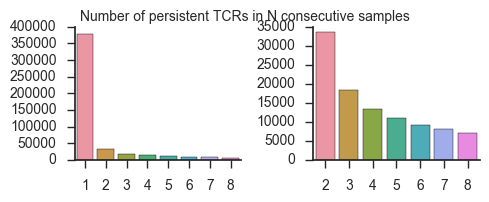

In [46]:
#plot the number of common TCR epitopes in the first N samples
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Number of persistent TCRs in N consecutive samples')

ax1 = fig.add_subplot(1,2,1)
sns.barplot(x=np.arange(1, 9), y=intersection_vals)

ax2 = fig.add_subplot(1,2,2)
sns.barplot(x=np.arange(2, 9), y=intersection_vals[1:])

sns.despine()
plt.tight_layout()

So with these cumulative plots with 3 months of consectutive sampling we get down below 20K TCRs and 4 months gets below 15K, but this is still not all that discerning. Does using an abundance cut off make sense?

Look for TCRs that exhibit the mirror behavior, i.e., they last in the later samples and arise midway through the collections.

In [47]:
#look at how many TCRs are in the shared TCR in N consecutive samples, starting from the end
intersection_vals_rev = []
for i in range(1,9):
    tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[-i:]])
    intersection_vals_rev.append(len(tcrs))

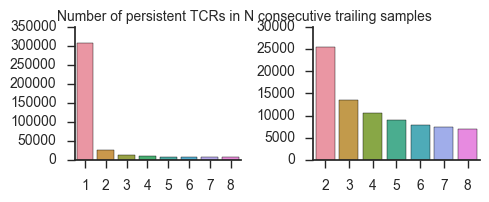

In [51]:
#plot the number of common TCR epitopes in the last N samples
fig = plt.figure(figsize=(5, 2))
plt.suptitle('Number of persistent TCRs in N consecutive trailing samples')

ax1 = fig.add_subplot(1,2,1)
sns.barplot(x=np.arange(1, 9), y=intersection_vals_rev)

ax2 = fig.add_subplot(1,2,2)
sns.barplot(x=np.arange(2, 9), y=intersection_vals_rev[1:])

sns.despine()
plt.tight_layout()

In [52]:
print(intersection_vals)
print(intersection_vals_rev)

[378865, 33601, 18368, 13514, 10997, 9141, 8218, 7012]
[307479, 25417, 13604, 10561, 8889, 7956, 7415, 7012]


These numbers do not indicate whether or not a given TCR is present in only the early samples (which would indicate extinction) or in only the later samples (which would relect new generation of TCRs). They do not exclude TCRs that are found earlier or later.

### Look for TCRs that arise or go extinct permanently during the time course
To find these TCRs, we need to identify TCRs that are shared in the beginning, end, or middle and establish whether they appear anywhere else. We can do this by comparing the set of TCRs that occur in n samples with the set of TCRs that occur in n consecutive samples. The intersection of these sets ought to be the desired TCRs.

In [10]:
#find TCRs that disappear
disappear_sets = {}
for i in range(1,9):
    #get TCRs in i consecutive samples
    consecutive_tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[:i]])
    #get TCRs found in only i samples
    i_tcrs = sub1_epi_occurence.loc[sub1_epi_occurence['num_occ_in_sub1_pbmc'] == i]['tcr_epitope'].unique()
    #get intersection
    disappear_sets[i] = set(i_tcrs).intersection(consecutive_tcrs)

In [13]:
#find TCRs that appear
appear_sets = {}
for i in range(1,9):
    #get TCRs in i consecutive samples
    consecutive_tcrs = set.intersection(*[set(tcre_sets[x]) for x in sample_list[-i:]])
    #get TCRs found in only i samples
    i_tcrs = sub1_epi_occurence.loc[sub1_epi_occurence['num_occ_in_sub1_pbmc'] == i]['tcr_epitope'].unique()
    #get intersection
    appear_sets[i] = set(i_tcrs).intersection(consecutive_tcrs)

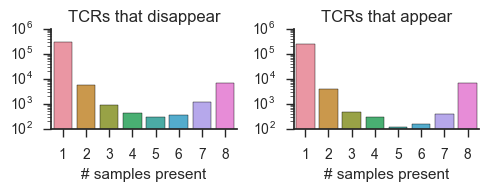

In [18]:
#plot TCRs that disappear and appear
fig = plt.figure(figsize=(5, 2))

ax1 = fig.add_subplot(1,2,1)
tmp = disappear_sets.items()
sns.barplot(x=[x[0] for x in tmp], y=[len(y[1]) for y in tmp])
plt.title('TCRs that disappear')
plt.xlabel('# samples present')
plt.yscale('log')

ax1 = fig.add_subplot(1,2,2)
tmp = appear_sets.items()
sns.barplot(x=[x[0] for x in tmp], y=[len(y[1]) for y in tmp])
plt.title('TCRs that appear')
plt.xlabel('# samples present')
plt.yscale('log')

sns.despine()
plt.tight_layout()

So interestingly, there is an odd uptick in TCRs that appear in the first or last 6-7 samples only, perhaps because these TCRs are part of the persistent TCR repertoire, but only happened to be missed in the last sampling. There do seem to be a bit more TCRs that disappear than reappear, but this difference is marginal. The lowest frequency seems to be lowest at 5 samples (TCRs that were around for 5 samples and then disappeared, or appeared after 3 samples). This creates another bimodal curve suggesting a distinct difference in those TCRs that are reliably present, and those that are rare enough or get cut out of the repertoire.

This might suggest that samples from the 6, 7, and 8 categories are the true persistent TCR, and the others are the rare TCR.

Of these TCRs that either disappear or appear, are any of them of notable abundance?

# Overall inter- and intra-individual variation

Destined for Figure 1 of the paper. How do samples cluster together? Either by jaccard, overlap, or JSD/shared JSD distance

This is generally going to be too memory intensive for my personal computer, so everything is run on AWS.

In [ ]:
import matplotlib.pyplot as plt, random, itertools
import pandas as pd, numpy as np, seaborn as sns, skbio.diversity as div

In [ ]:
#read in data from /home/ubuntu/users/ndchu/tcr/tcrb_timecourse
timecourse = pd.read_csv('all_subjects_timecourse.tsv.gz',
                         sep='\t', compression='gzip')
occurence_data = pd.read_csv('tcr_epitopes_occurence_all.tsv.gz',
                             sep='\t', compression='gzip')

In [ ]:
samples_all = timecourse['sample'].unique()

In [ ]:
#first look at overlap/jaccard distance between all samples
#NO RAREFACTION
samples_all = timecourse['sample'].unique() #list of samples

overlap_mx = pd.DataFrame(index=samples_all, columns=samples_all)
jaccard_mx = pd.DataFrame(index=samples_all, columns=samples_all)

for i, j in itertools.combinations(samples_all, 2):
    tcrs_1 = timecourse.loc[timecourse['sample'] == i]['tcr_epitope'].unique()
    tcrs_2 = timecourse.loc[timecourse['sample'] == j]['tcr_epitope'].unique()
    overlap = len(set(tcrs_1) & set(tcrs_2))
    jaccard = overlap / len(set(tcrs_1) | set(tcrs_2))
    overlap_mx.ix[i, j] = overlap
    overlap_mx.ix[j, i] = overlap
    jaccard_mx.ix[i, j] = jaccard
    jaccard_mx.ix[j, i] = jaccard

#add values on the diagonal just for shits
for i in samples_all:
    overlap_mx.ix[i, i] = timecourse.loc[timecourse['sample'] == i]['tcr_epitope'].nunique()
    jaccard_mx.ix[i, i] = 1

In [ ]:
#write these values to a table, transfer to local machine
overlap_mx.to_csv('overlap_mtx.tsv', sep='\t')
jaccard_mx.to_csv('jaccard_mtx.tsv', sep='\t')

In [4]:
#read tables in local ipython notebook
overlap_mx = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/overlap_mtx.tsv',
                        sep='\t', index_col=0)
jaccard_mx = pd.read_csv('/Users/ndchu/Documents/tcr_fmt/tcrb_timecourse/jaccard_mtx.tsv',
                        sep='\t', index_col=0)

In [38]:
#optional to set the diagonal values to zero
overlap_mx_0 = overlap_mx
jaccard_mx_0 = jaccard_mx
for i in overlap_mx.index:
    overlap_mx_0.ix[i, i] = 0
    jaccard_mx_0.ix[i, i] = 0

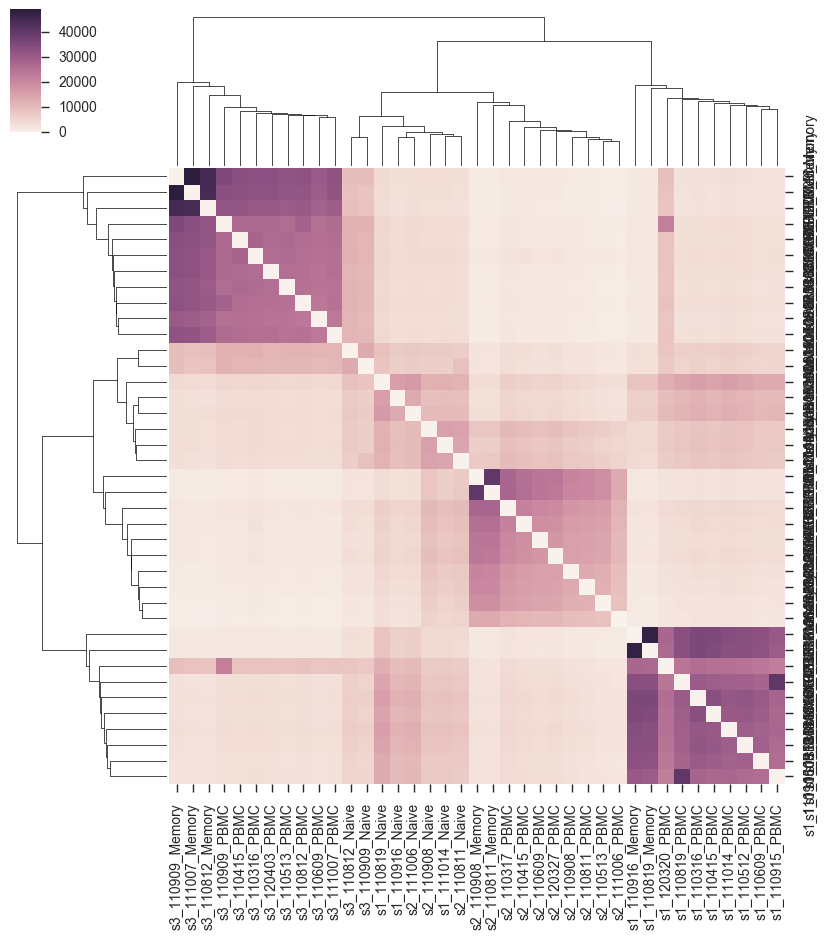

In [30]:
#now we can clustermap the samples, both with and without 
#Naive and memory cells
sns.clustermap(overlap_mx)

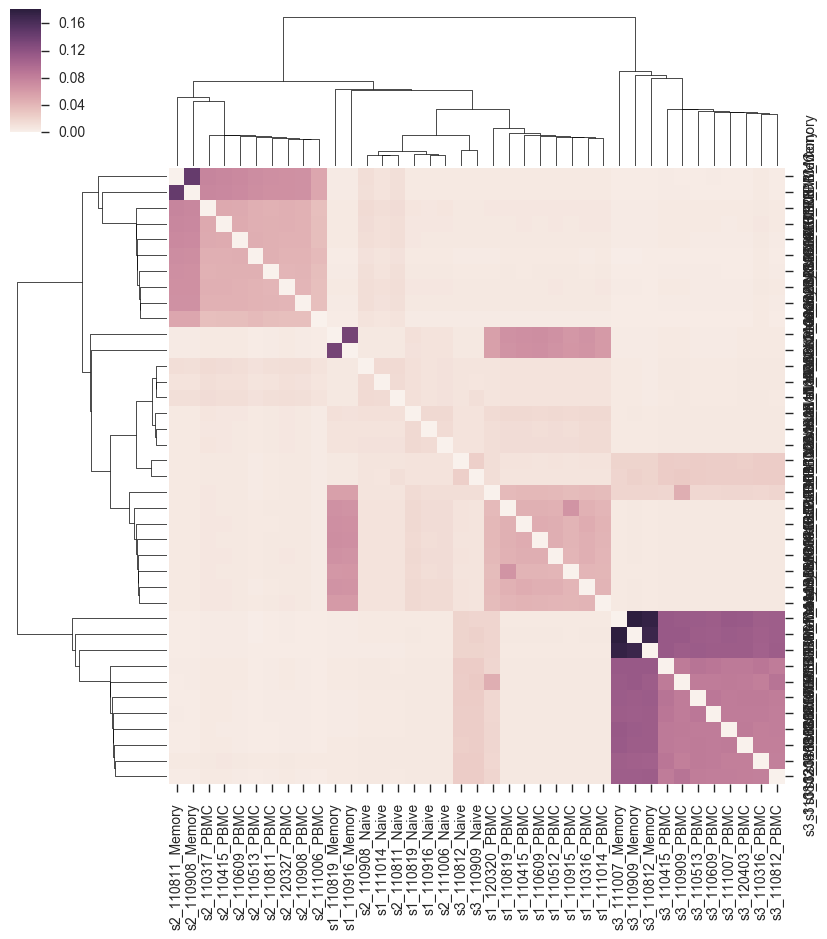

In [31]:
#now we can clustermap the samples, both with and without 
#Naive and memory cells
sns.clustermap(jaccard_mx)

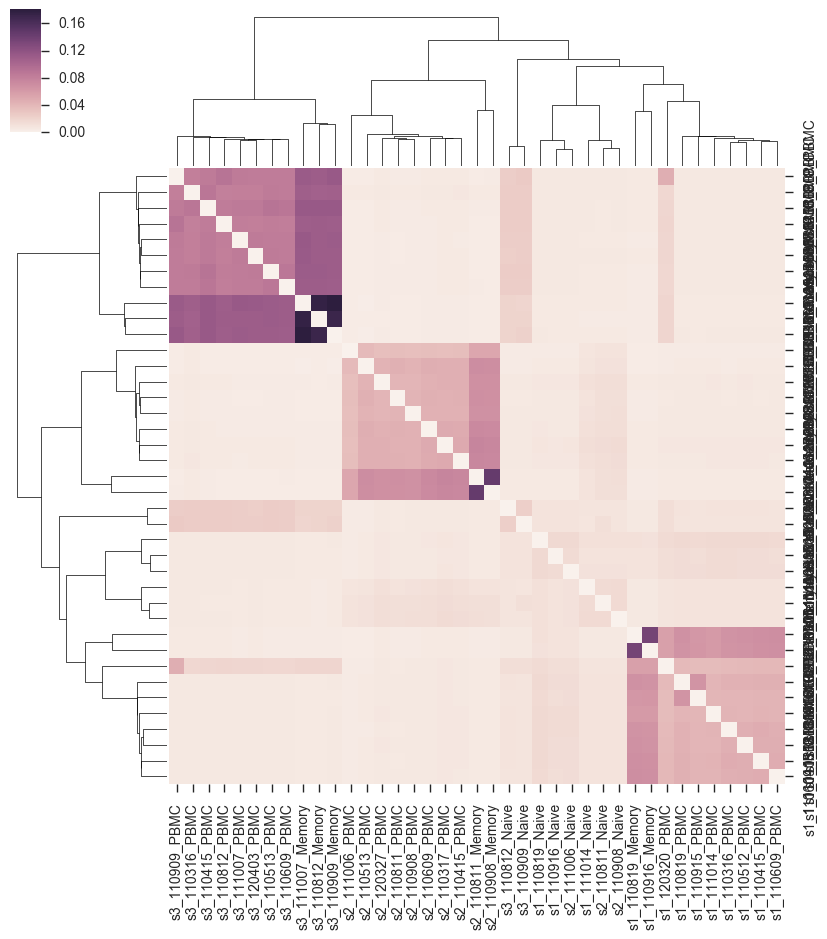

In [88]:
#We can redo this clustermap using the jaccard values as the distances used
#to call the dendrogram by passing them to the linkage field
sns.clustermap(jaccard_mx_0, method='single', metric='braycurtis')

In [ ]:
#or in the final iteration we can manually pass the linkage map too clustermap


In [ ]:
import scipy.cluster.hierarchy as hc
hc.linkage(jaccard_mx_0)

In [67]:
#For MDS, get the Jaccard distances
jaccard_dist = 1 - jaccard_mx

In [68]:
for i in jaccard_dist.index:
    jaccard_dist.ix[i, i] = 0

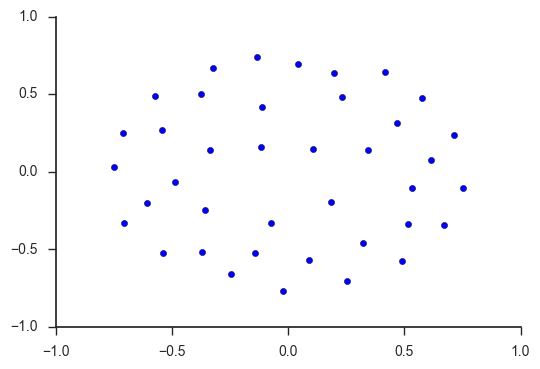

In [84]:
#we can also make an MDS plot of this matrix, using 2 components
mds = manifold.MDS(n_components=2, max_iter=100, n_init=1, 
                   dissimilarity='precomputed')
Y = mds.fit_transform(jaccard_dist)

#plot the mds points
plt.scatter(Y[:, 0], Y[:, 1])

sns.despine()

Jaccard distance appears to be a poor input for MDS for this kind of data, since the differences are very small when put into the context of the overall size of the TCR repertoire, effectively swamping out the sigifincant signal between samples. The most reasonable so far has been the plot of pure overlap, where no regard is given to the overall size of the datasets involved. We can probably exaggerate or otherwise highlight the differences, but all of those means would be kinda janky.

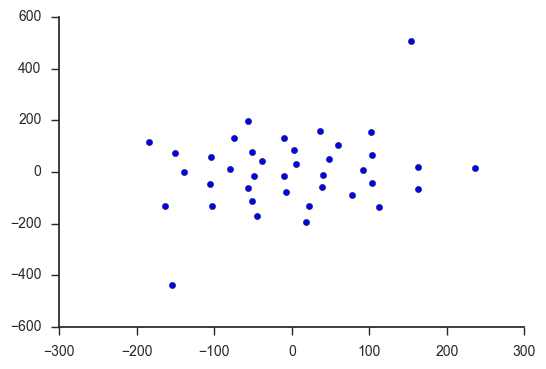

In [76]:
#see if tsne does any better (doesn't do much better)
mds = manifold.TSNE(n_components=2, metric='precomputed')
Y = mds.fit_transform(jaccard_dist)

#plot the mds points
plt.scatter(Y[:, 0], Y[:, 1])

sns.despine()

So tsne also fails to satisfactorily cluster the data, I'm not exaclty sure why. 

In [14]:
#make a mask to cover the upper triangle
mask = np.zeros_like(jaccard_mx)
mask[np.triu_indices_from(mask)] = True
mask

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  0.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

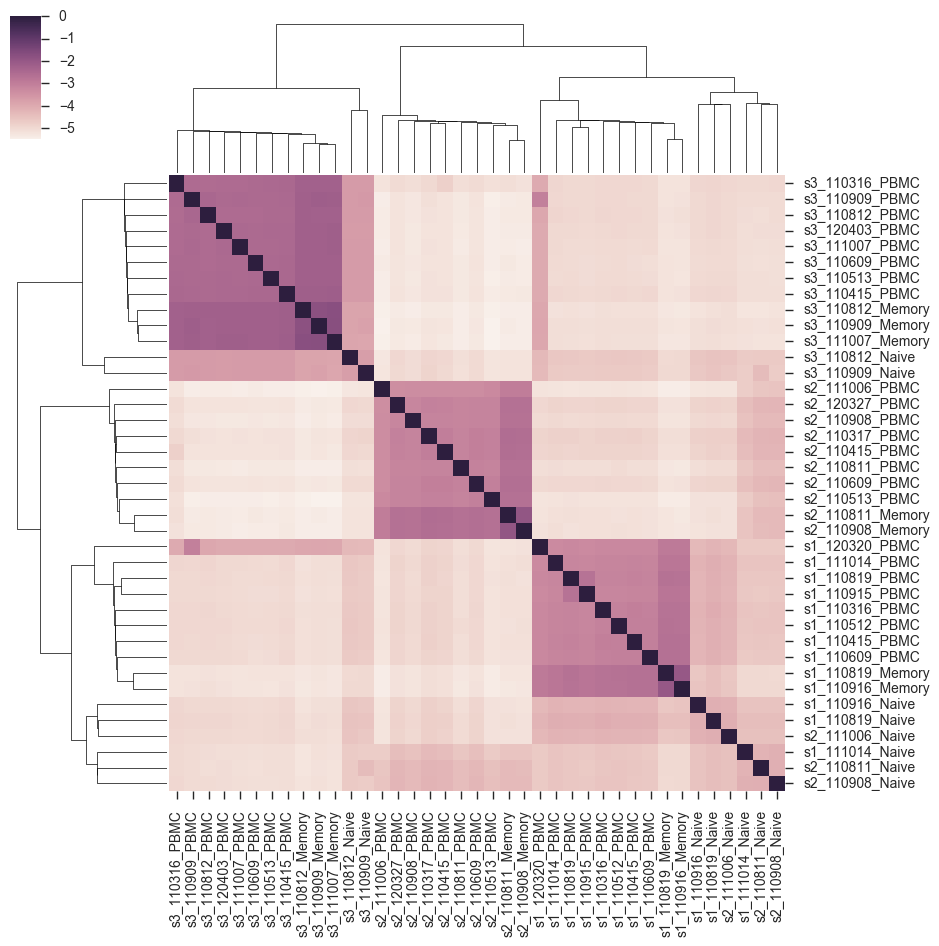

In [23]:
#try doing a clustermap on the log(jaccard distance)
jaccard_mx_lg = np.log(jaccard_mx)

g = sns.clustermap(jaccard_mx_lg)
tmp = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

So in order to rotate the clusters in a way that groups the rows more intelligently, I'm going to have to rebuild this figure using a heatmap and making a new dendrogram manually. The goal will be to have the naive cells of S1 and S2 between those two samples, better visualzing the clusters.

In [57]:
#manipulate linkage group positions in the tree
import scipy.cluster.hierarchy as hc
tmp = hc.linkage(jaccard_mx_lg)

In [43]:
def get_newick(node, newick, parentdist, leaf_names):
    """
    A script from stackoverflow user jfn 
    (https://stackoverflow.com/questions/28222179/save-dendrogram-to-newick-format)
    
    Converts the tree output from the method to_tree from scipy.cluster.hierarchy
    to a newick tree format
    
    leaf_names is a dictionary with keys being the leaf labels (in a scipy linkage
    obejct, these labels are the indexes in the original pandas df) and values being
    the column names/sample names
    """
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

In [55]:
#Get a newick tree from the hierachy clustering, plots this tree with a heatmap
linkage_jc_lg = hc.linkage(jaccard_mx_lg)
tree = hc.to_tree(linkage_jc_lg, False)
leaf_names = {i: val for i, val in enumerate(jaccard_mx_lg.columns)}
jc_lg_nwk = get_newick(tree, "", tree.dist, leaf_names=leaf_names)

So there are perhaps ways of getting around this, but it probably is more of a headache than is worth it. Let's just go with a heatmap (the order can be determined specifically), and then other plots can look at the similarities between the samples (like a dot plot or similar).

In [87]:
def color_sample(sample, metadata_sample, palette):
    """
    Small function for assiging colors
    """
    colors_dict = {'subject01': 0, 'subject02': 1, 'subject03': 2, 
                  'PBMC': 3, 'Memory': 4, 'Naive': 5}
    tmp = metadata_sample.ix[sample]
    return [palette[colors_dict[tmp['individual']]], palette[colors_dict[tmp['cells']]]]

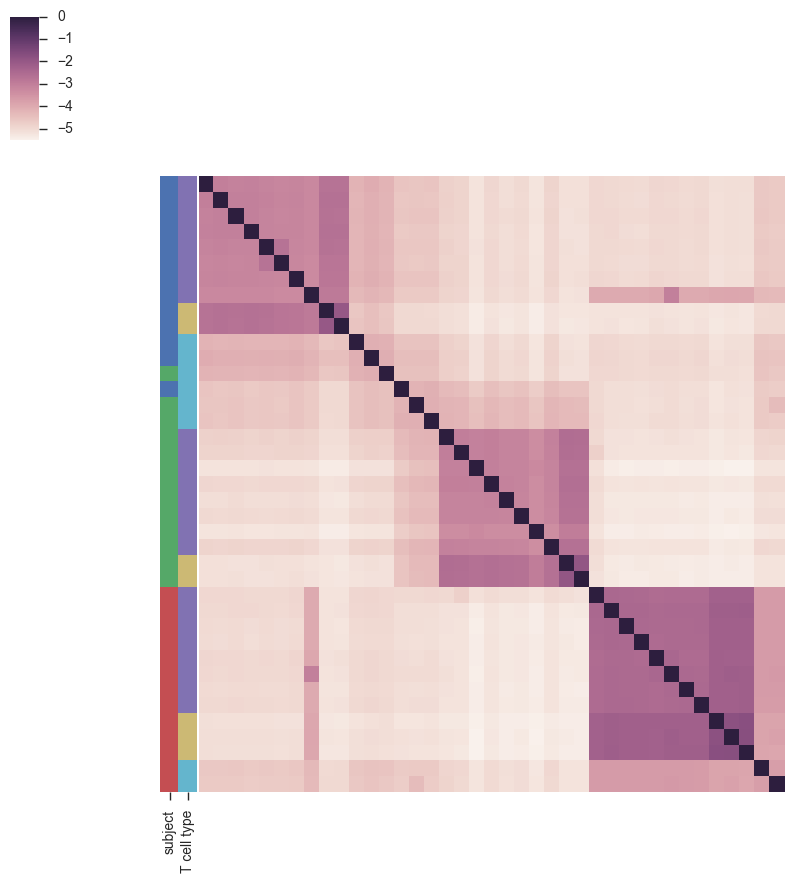

In [105]:
#set the column and row order
sample_order = ['s1_110316_PBMC', 's1_110415_PBMC', 's1_110512_PBMC',
               's1_110609_PBMC', 's1_110819_PBMC', 's1_110915_PBMC', 's1_111014_PBMC',
               's1_120320_PBMC', 's1_110819_Memory', 's1_110916_Memory', 's1_110916_Naive',
               's1_110819_Naive', 's2_111006_Naive', 's1_111014_Naive', 's2_110811_Naive',
               's2_110908_Naive', 's2_110317_PBMC', 's2_110415_PBMC', 's2_110513_PBMC',
               's2_110609_PBMC', 's2_110811_PBMC', 's2_110908_PBMC', 's2_111006_PBMC',
               's2_120327_PBMC', 's2_110811_Memory', 's2_110908_Memory', 's3_110316_PBMC',
               's3_110415_PBMC', 's3_110513_PBMC', 's3_110609_PBMC', 's3_110812_PBMC',
               's3_110909_PBMC', 's3_111007_PBMC', 's3_120403_PBMC', 's3_110812_Memory',
               's3_110909_Memory', 's3_111007_Memory', 's3_110812_Naive', 's3_110909_Naive']

#make vectors to color the rows by individual and T cell subset
palette = sns.color_palette()
colors = pd.DataFrame([color_sample(sample, metadata_sample, palette) for sample in sample_order],
                     index=sample_order)
colors = colors.rename(columns={0: 'subject', 1:'T cell type'})

#plot the bottom half of this heatmap
sns.clustermap(jaccard_mx_lg.reindex(sample_order)[sample_order],
               row_colors=colors, row_cluster=False, col_cluster=False, xticklabels=False, 
               yticklabels=False)

In [ ]:
#Compute JSD between different samples
#NO RAREFACTION
samples_all = timecourse['sample'].unique() #list of samples

jsd_mx = pd.DataFrame(index=samples_all, columns=samples_all) #final results tables
jsd_shr_mx = pd.DataFrame(index=samples_all, columns=samples_all)

for i, j in itertools.combinations(samples_all, 2):
    #get each sample's dataframe
    tcrs_1 = timecourse.loc[timecourse['sample'] == i][['tcr_epitope', 'freq']]
    tcrs_2 = timecourse.loc[timecourse['sample'] == j][['tcr_epitope', 'freq']]
    #sum over tcr clonotypes (collapse by tcr_epitope)
    tcrs_1 = tcrs_1.groupby('tcr_epitope', as_index=False).sum()
    tcrs_2 = tcrs_2.groupby('tcr_epitope', as_index=False).sum()
    
    #get series
    tcrs_1 = tcrs_1.set_index('tcr_epitope')['freq'].rename(i)
    tcrs_2 = tcrs_2.set_index('tcr_epitope')['freq'].rename(j)
    
    #concatenate with nans
    df = pd.concat([tcrs_1, tcrs_2], axis=1)
    df_shr = df.dropna() #shared column drops nans
    df = df.fillna(0) #now fill with zeros
    jsd = jensen_shannon(df[i], df[j]) #calculate jsd
    jsd_shr = jensen_shannon(df_shr[i], df_shr[j])
    jsd_mx.ix[i, j] = jsd
    jsd_mx.ix[j, i] = jsd
    jsd_shr_mx.ix[i, j] = jsd_shr
    jsd_shr_mx.ix[j, i] = jsd_shr

#add values on the diagonal just for shits
for i in samples_all:
    jsd_mx.ix[i, i] = 0
    jsd_shr_mx.ix[i, i] = 0

In [ ]:
#write jsd values to a table, transfer to local machine
jsd_mx.to_csv('jsd_mx.tsv', sep='\t')
jsd_shr_mx.to_csv('jsd_shr_mx.tsv', sep='\t')

In [72]:
#read in jsd tables
jsd_mx = pd.read_csv('~/Documents/tcr_fmt/tcrb_timecourse/jsd_mx.tsv', sep='\t',
                    index_col=0)
jsd_shr_mx = pd.read_csv('~/Documents/tcr_fmt/tcrb_timecourse/jsd_shr_mx.tsv', sep='\t',
                    index_col=0)

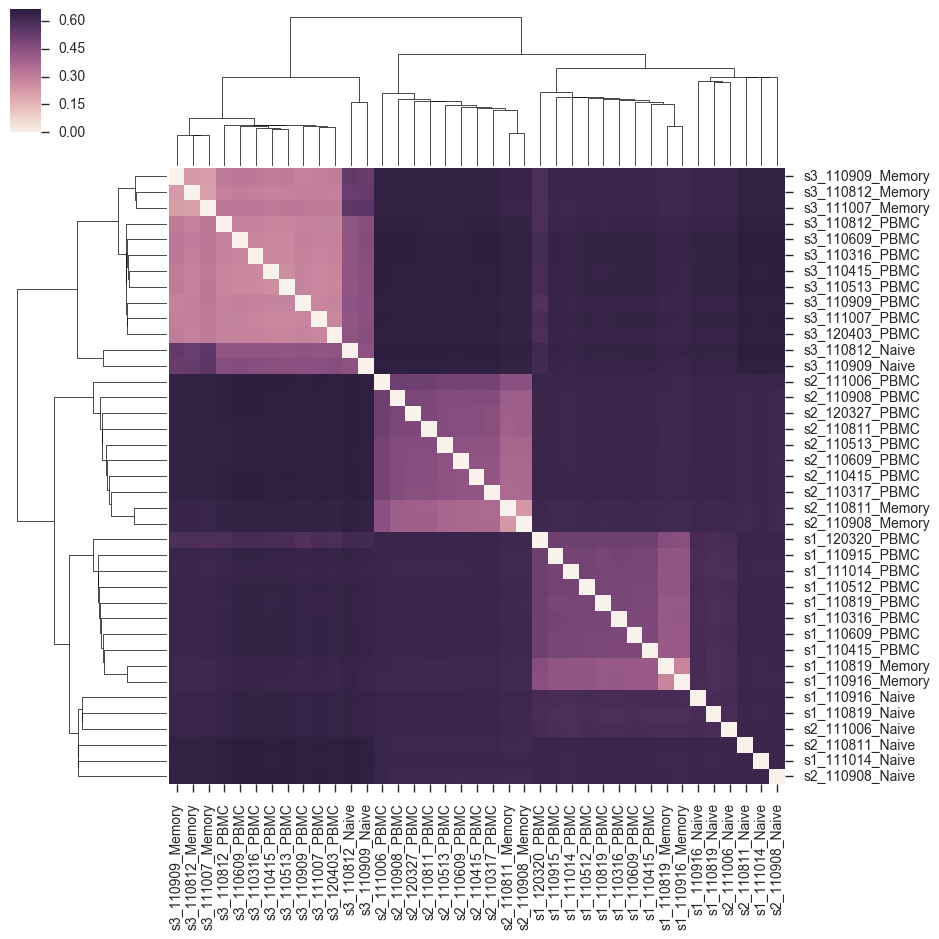

In [74]:
#plot a clustermap of matrices
g = sns.clustermap(jsd_mx)
tmp = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

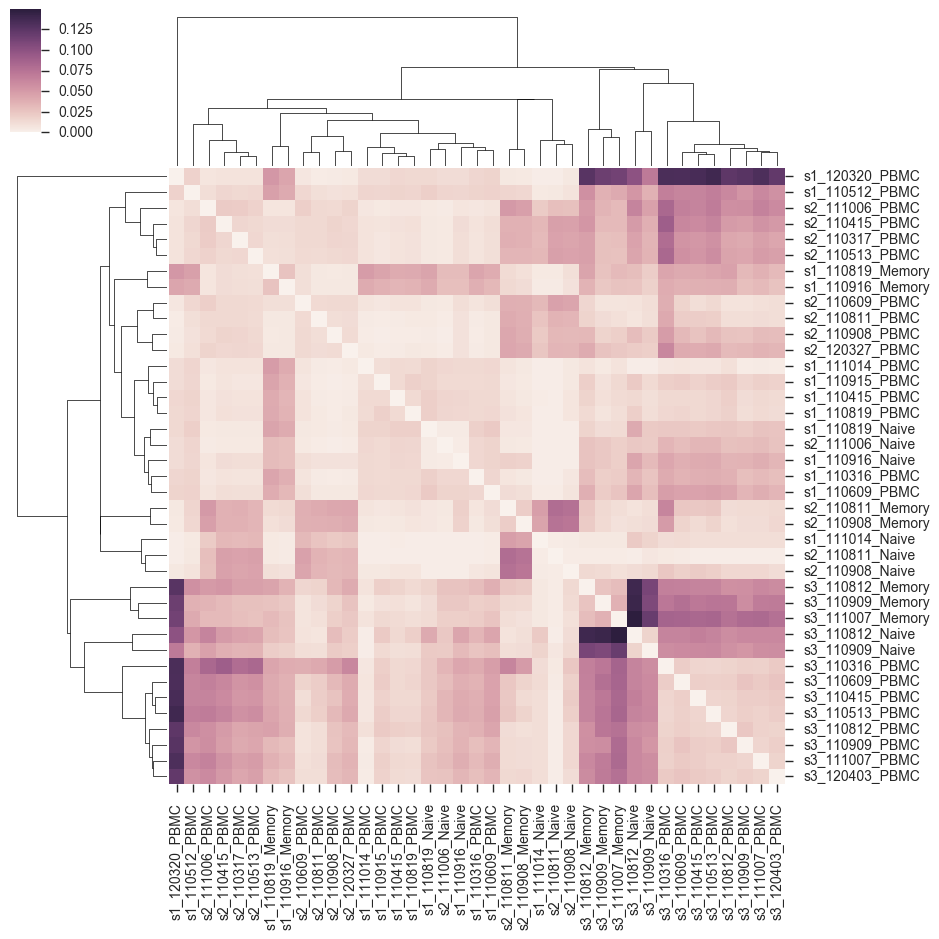

In [75]:
#plot a clustermap of matrices
g = sns.clustermap(jsd_shr_mx)
tmp = plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

So total JSD looks very much like the overlap and jaccard distances, since most of the information is presence absense. The shared JSD looks very different, since now abundances come into play. Honestly, it looks pretty random and not that informative.

## Alpha diveristy over time

In [ ]:
#Look at shannon alpha diversity through time
alpha_vals = {}
for sample, sub_df in timecourse.groupby('sample'):
    shannon = alpha.shannon(sub_df.groupby('tcr_epitope').sum()['count'])
    alpha_vals[sample] = shannon
    
#make a dataframe
alpha_df = pd.DataFrame(list(alpha_vals.items()), columns=['sample', 'shannon_alpha'])
#add shannon estimate
alpha_df['shannon_estimate'] = alpha_df['shannon_alpha'].apply(lambda x: np.exp(x))

#write it to a file
alpha_df.to_csv('alpha_shannon.tsv', sep='\t', index=False)

In [114]:
#read in alpha shannon values
alpha_df = pd.read_csv('~/Documents/tcr_fmt/tcrb_timecourse/alpha_shannon.tsv', sep='\t')

In [132]:
#first add relavant metadata (time, individual x cell type)
time_dict = metadata.set_index('sample_short').to_dict()['time']
alpha_df['time'] = alpha_df['sample'].apply(lambda x: time_dict[x])
ind_dict = metadata.set_index('sample_short').to_dict()['individual']
cell_dict = metadata.set_index('sample_short').to_dict()['cells']
alpha_df['ind_cell'] = alpha_df['sample'].apply(lambda x: (ind_dict[x], cell_dict[x]))
alpha_df['time_num'] = alpha_df['time'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').date().toordinal())

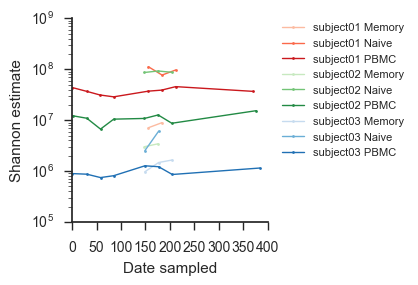

In [164]:
#now plot each time series

colors = sns.color_palette('Reds', n_colors=3) + \
         sns.color_palette('Greens', n_colors=3) + \
         sns.color_palette('Blues', n_colors=3)
samples = alpha_df['ind_cell'].sort_values().unique()
color_dict = dict(zip(samples, colors))

fig = plt.figure(figsize=(3, 3))

for ind_cell, sub_df in alpha_df.groupby('ind_cell'):
    plot_name = ind_cell[0] + ' '  + ind_cell[1]
    plt.plot(sub_df['time_num'], sub_df['shannon_estimate'], '-o', label=plot_name, 
             color=color_dict[ind_cell], markersize=2, linewidth=1)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
          fontsize=8)
plt.yscale('log')
plt.xlabel('Date sampled')
plt.ylabel('Shannon estimate')
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

Let's get frequency correlation plots for all sample combinations just so we can check over all patterns. We'll do this on aws and export to a png image.

## TCR frequency correlations

In [ ]:
#ONLY IF USING A SERVER (SET DISPLAY SETTINGS)
import matplotlib
matplotlib.use('AGG')
sns.set_style('white')

In [ ]:
#plot correlations, each as it's own file
sns.set_style('white')

samples_all = timecourse['sample'].unique() #list of samples
combs = list(itertools.combinations(samples_all, 2))
rows = int(np.ceil(len(combs)/6))

for i, j in itertools.combinations(samples_all, 2):
    #get each sample's dataframe
    tcrs_1 = timecourse.loc[timecourse['sample'] == i][['tcr_epitope', 'freq']]
    tcrs_2 = timecourse.loc[timecourse['sample'] == j][['tcr_epitope', 'freq']]
    #sum over tcr clonotypes (collapse by tcr_epitope)
    tcrs_1 = tcrs_1.groupby('tcr_epitope', as_index=False).sum()
    tcrs_2 = tcrs_2.groupby('tcr_epitope', as_index=False).sum()
    #get series
    tcrs_1 = tcrs_1.set_index('tcr_epitope')['freq'].rename(i)
    tcrs_2 = tcrs_2.set_index('tcr_epitope')['freq'].rename(j)
    
    fig = plot_freq_comparison(tcrs_1, tcrs_2, return_axes=True)
    sns.despine()
    
    file_str = 'correlation_' + i + '_' + j + '.png'
    
    fig.savefig(file_str)
    plt.close(fig)

## Barplots of the persistent TCR repertoire

(a) The number of samples we observe each TCR is bimodally distributed. Persistent TCRs tend to be more abundant (b), have greater clonotype: epitope ratios (c), length (d), 


In [5]:
#get the number of occurences over all patients and remove zeros
pers1 = Counter(epitope_occurence['num_occ_in_sub1_pbmc'])
pers1.pop(0, None)
pers2 = Counter(epitope_occurence['num_occ_in_sub2_pbmc'])
pers2.pop(0, None)
pers3 = Counter(epitope_occurence['num_occ_in_sub3_pbmc'])
pers3.pop(0, None)

totals = [sum(x.values()) for x in [pers1, pers2, pers3]]
pers1 = {k: v/totals[0] for k, v in pers1.items()}
pers2 = {k: v/totals[1] for k, v in pers2.items()}
pers3 = {k: v/totals[2] for k, v in pers3.items()}

#get mean values
pers_total = Counter(pers1) + Counter(pers2) + Counter(pers3)
pers_total = {k: v/3 for k, v in pers_total.items()}

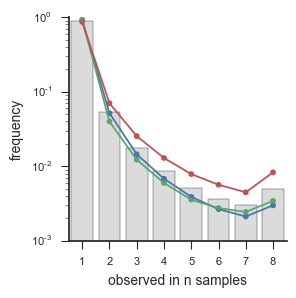

In [44]:
#plotting as KDE was ugly
#instead try barplots with lines

keys = list(pers1.keys()) + list(pers2.keys()) + list(pers3.keys())
values = list(pers1.values()) + list(pers2.values()) + list(pers3.values())

afont = {'fontname':'Arial'} #change fonts
#sns.set_style('white')
sns.set_style('ticks', {'font.family': 'Arial'})
sns.set_context('paper', rc={'font.size': 8, "axes.labelsize": 7})

fig = plt.figure(figsize=(3, 3))
sns.barplot(x=list(pers_total.keys()), y=list(pers_total.values()), 
        color=sns.color_palette('gray')[5], ci=None, zorder=0)
sns.pointplot(list(pers1.keys()), list(pers1.values()), ci=None, 
              scale=.5, color=sns.color_palette()[0], zorder=5)
sns.pointplot(list(pers2.keys()), list(pers2.values()), ci=None, 
              scale=.5, color=sns.color_palette()[1], zorder=10)
sns.pointplot(list(pers3.keys()), list(pers3.values()), ci=None, 
              scale=.5, color=sns.color_palette()[2], zorder=15)

plt.xlabel('observed in n samples', fontsize=10)
plt.ylabel('frequency', fontsize=10)

plt.yscale('log')
sns.despine()
plt.tight_layout()

In [ ]:
#what if we plot the cululative abundance in the dataset?

Before we plot the actual figures, let's reevaluate the idea of **clonotype: epitope ratio** a little more critically.

How do we know these aren't just errors from more abundant sequences? We can filter out some of these instances with a few different options:
    *Only consider clonotypes within X orders of magnitude of the most common clonotype
    *Make this cut off based on the overlap in variance between different clonotypes
    *Clonotypes must occur in x samples
    *

Other questionable options include looking at the nucleotide sequences for clonotypes with more differences.

We'll define clonotype

In [ ]:
#read in data from /home/ubuntu/users/ndchu/tcr/tcrb_timecourse
timecourse = pd.read_csv('all_subjects_timecourse.tsv.gz',
                         sep='\t', compression='gzip')
#metadata
metadata = pd.read_csv('tcrb_timecourse_metadata.txt', sep='\t')

#read in the full time course, with nucleotide and aminoAcid information
timecourse_full = pd.read_csv('all_subjects_timecourse_w_nuc_aa.tsv.gz',
                              sep='\t', compression='gzip')

In [ ]:
#over all TCR epitopes, generally how many clonotypes?
ind_dict = metadata.set_index('sample_short').to_dict()['individual']
timecourse['individual'] = timecourse['sample'].apply(lambda x: ind_dict[x]) #add subject

tmp_df = timecourse[['tcr_epitope', 'tcr_clonotype', 'individual']]
clones_per_epitope_wsub = tmp_df.groupby(['tcr_epitope', 
                                          'individual'])['tcr_clonotype'].nunique().reset_index(name='clonotype_count')
clones_per_epitope_wsub.to_csv('clonotypes_per_epitope.tsv.gz', sep='\t', index=False,
                              compression='gzip')

#read back in clonotype/epitope information
clones_per_epitope_wsub = pd.read_csv('clonotypes_per_epitope.tsv.gz', sep='\t', 
                                       compression='gzip')

#plot and save figure
sns.distplot(clones_per_epitope_wsub['clonotype_count'], kde=False, norm_hist=True)
plt.yscale('log')
sns.despine()
plt.savefig('figures/clonotypes_per_epitope_hist.pdf')
plt.clf()

In [ ]:
#do distributions from different subjects look different?
sns.distplot(clones_per_epitope_wsub['clonotype_count'], kde=False, norm_hist=True)
sns.distplot(clones_per_epitope_wsub[clones_per_epitope_wsub['individual'] == 'subject01']['clonotype_count'], 
             kde=False, norm_hist=True)
sns.distplot(clones_per_epitope_wsub[clones_per_epitope_wsub['individual'] == 'subject02']['clonotype_count'], 
             kde=False, norm_hist=True)
sns.distplot(clones_per_epitope_wsub[clones_per_epitope_wsub['individual'] == 'subject03']['clonotype_count'], 
             kde=False, norm_hist=True)
plt.yscale('log')
sns.despine()
plt.savefig('figures/clonotypes_per_epitope_hist_byind.pdf')
plt.clf()
#no they do not look different across subjects

In [ ]:
#What is the spread of TCR clonotype abundances?
#specifically, within a TCR epitope, what is the distribution of mean clonotype abundances
#as a fraction of the overall TCR epitope abundance?

#first get mean abundance of each TCR epitope and clonotype in each person
#only consider PBMC samples
cell_dict = metadata.set_index('sample_short').to_dict()['cells']
timecourse['cells'] = timecourse['sample'].apply(lambda x: cell_dict[x]) #add subject
ind_dict = metadata.set_index('sample_short').to_dict()['individual']
timecourse['individual'] = timecourse['sample'].apply(lambda x: ind_dict[x]) #add subject

tmp_df = timecourse[timecourse['cells'] == 'PBMC']

#epitope mean frequency within individual and only in PBMCs
epitope_mean_freq = tmp_df[['tcr_epitope', 
                            'individual', 
                            'freq']].groupby(['tcr_epitope',
                                    'individual']).mean().reset_index()
epitope_mean_freq.to_csv('epitope_mean_freq_pbmc.tsv.gz', sep='\t', 
                                       compression='gzip', index=False)

In [ ]:
#clonotype mean within individual and tcr epitope
clonotype_mean_freq = tmp_df[['tcr_epitope', 
                              'individual', 
                              'tcr_clonotype',
                              'freq']].groupby(['tcr_epitope',
                                                'individual',
                                                'tcr_clonotype']).mean().reset_index()
clonotype_mean_freq = clonotype_mean_freq.rename(columns={'freq': 'mean_freq_clonotype'})
clonotype_mean_freq.to_csv('clonotype_mean_freq_pbmc.tsv.gz', sep='\t',
                          compression='gzip', index=False)

#So now that we know the mean abundances of clonotypes, what is the usual spread of these
#values? We'll look at the log of these values
clonotype_mean_freq['lg_mean_freq'] = clonotype_mean_freq['mean_freq_clonotype'].apply(np.log10)

clonotype_mean_freq_var = clonotype_mean_freq.groupby(['tcr_epitope', 'individual']).var().reset_index()
clonotype_mean_freq_var = clonotype_mean_freq_var.rename(columns={'mean_freq_clonotype': 'mean_freq_clonotype_var',
                                                                 'lg_mean_freq': 'lg_mean_freq_var'})
clonotype_mean_freq_var.to_csv('clonotype_mean_freq_pbmc_var_per_epi.tsv.gz', sep='\t', 
                               compression='gzip', index=False)

#read back in this information
clonotype_mean_freq_var = pd.read_csv('clonotype_mean_freq_pbmc_var_per_epi.tsv.gz', 
                                      sep='\t', compression='gzip')

In [ ]:
#plot variances of clonotype mean abundances within each TCR epitope
sns.distplot(tmp, kde=False, norm_hist=True)
plt.yscale('log')
plt.xlabel('Variance of log(mean freq) of clonotypes of a given epitope')
sns.despine()
plt.savefig('figures/var_lgmean_clonotypes.pdf')
plt.clf()

#So on a log scale, we have a pretty steady decline in values, meaning that
#the large majority of tcr clonotypes actually have

So when evaluating clonotype: epitope ratio, I think the one important part is not what single cut off would get rid of errors, but whether or not the signals of clonotype: epitope ratio is robust to different cutoffs. If it's not, then it's likely that the whole signal is from very rares TCR clonotypes that may or may not be errors.

In addition, it looks like a large portion of clonotypes are some sort of error, but that these errors are rare. Thus, by either filtering out clonotypes that only occur in a single sample within an individual (or even across individuals) we would get rid of a lot of these errors.

Since most of these errors are probably just sequencing errors, we could pretty reasonably merge them back into the TCR epitope that they came from. However, there might be fringe cases where an error might push a TCR clonotype into a different TCR epitope bin.

In [ ]:
#How many reads/TCR clonotypes only occur once?
clonotype_num_samples = timecourse.groupby('tcr_clonotype').size().reset_index()
clonotype_num_samples = clonotype_num_samples.rename(columns={0: 'n_samples'})
clonotype_n_sam_counter = Counter(clonotype_num_samples['n_samples'])

Counter({1: 8495153, 2: 325081, 3: 104180, 4: 53160, 5: 33154, 6: 22055, 7: 16237, 8: 12842, 10: 11310, 9: 11000, 11: 6975, 12: 3949, 13: 2354, 14: 1401, 15: 192, 16: 119, 17: 77, 18: 44, 19: 41, 20: 21, 21: 16, 23: 15, 22: 11, 25: 9, 24: 8, 26: 6, 27: 6, 30: 5, 28: 4, 29: 1, 31: 1, 32: 1, 33: 1, 37: 1, 39: 1})

So the vast majority of TCR clonotypes only occur in a single sample, although this drop off is about the same as the drop off in TCR epitopes. This is probably because they are equivalent, many of these single-sample TCR clonotypes likely correspond to the huge number of epitopes. The more pertinent question is how many of these are also very low abundance.

So let's just look at the graph without any alterations and then check that the pattern holds in the following circumstances:
1. Different levels of subsampling
2. Cut off all TCR clonotypes that are more than 3, 4, 5, or 6 orders of magnitude smaller in abundance than the largest TCR clonotype
3. Remove all TCR clonotypes that only (a) occur in a single sample and (b) are less frequent that 10^-6 or 10^-7 (go for a cutoff of -6.5)

In [ ]:
#clonotype: epitope ratio calculate on the server
#calculate clonotype/epitope ratios within each subject, but across samples
cl_ep_ratio_dict = {}
for tcr, sub_df in timecourse[['tcr_clonotype', 'tcr_epitope']].groupby('tcr_epitope'):
    cl_ep_ratio_dict[tcr] = sub_df['tcr_clonotype'].nunique()
    
sub1_subsam['cl_ep_ratio'] = sub1_subsam['tcr_epitope'].apply(lambda x : cl_ep_ratio_dict[x])

/Users/ndchu/programfiles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


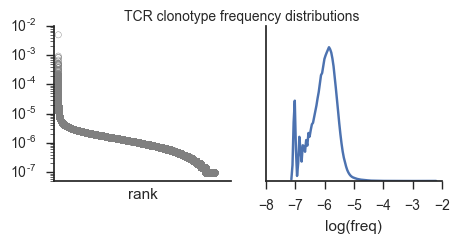

In [49]:
fig = plt.figure(figsize=(5, 2))
plt.suptitle('TCR clonotype frequency distributions')

ax1 = fig.add_subplot(1,2,1)
plot_ind_freq(sub1_timecourse.loc[sub1_timecourse['sample'] == 's1_110316_PBMC']['freq'],
             log=True)
plt.ylim(.00000005, .01)
plt.xlim(-10000, 450000)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
plt.xlabel('rank')

ax2 = fig.add_subplot(1,2,2)
tmp = sub1_timecourse.loc[sub1_timecourse['sample'] == 's1_110316_PBMC']['freq'].apply(np.log10)
sns.distplot(tmp, hist=False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
plt.tick_params(axis='y', which='both', left='off', labelleft='off')
plt.xlabel('log(freq)')

plt.show()

In [ ]:
#read in pertinent files
epi_occ = pd.read_csv('tcr_epitopes_occurence_all.tsv.gz', sep='\t', compression='gzip')
cln_epi_ratio = pd.read_csv('clonotypes_per_epitope.tsv.gz', sep='\t', compression='gzip')

In [ ]:
#regardless of any subsampling or cutoffs, plot TCR epitope persistence versus 
#clonotype: epitope ratio within each subject

##Subject01
sub1_epi_occ = epi_occ.loc[epi_occ['num_occ_in_sub1_pbmc'] > 0][['tcr_epitope', 'num_occ_in_sub1_pbmc']]
sub1_epi_occ = sub1_epi_occ.set_index('tcr_epitope')
sub1_cln_epi_ratio = cln_epi_ratio.loc[cln_epi_ratio['individual'] == 'subject01'].set_index('tcr_epitope')
#recall that cln_epi_ratio also has Naive and memory samples in it, so is larger than epi_occ

sub1_occ_clnrat = pd.concat([sub1_epi_occ, sub1_cln_epi_ratio], axis=1)#merge these tables
sub1_occ_clnrat = sub1_occ_clnrat.dropna() #remove rows with nans
subject01_data = (sub1_occ_clnrat['num_occ_in_sub1_pbmc'].tolist(), 
                     sub1_occ_clnrat['clonotype_count'].tolist()) #results
#subject01_data now a tuple of matched lists. The first list is the tcr epitope persistence
#The second is the clonotype:epitope ratios

## Subject02
sub2_epi_occ = epi_occ.loc[epi_occ['num_occ_in_sub2_pbmc'] > 0][['tcr_epitope', 'num_occ_in_sub2_pbmc']]
sub2_epi_occ = sub2_epi_occ.set_index('tcr_epitope')
sub2_cln_epi_ratio = cln_epi_ratio.loc[cln_epi_ratio['individual'] == 'subject02'].set_index('tcr_epitope')

sub2_occ_clnrat = pd.concat([sub2_epi_occ, sub2_cln_epi_ratio], axis=1)#merge these tables
sub2_occ_clnrat = sub2_occ_clnrat.dropna() #remove rows with nans
subject02_data = (sub2_occ_clnrat['num_occ_in_sub2_pbmc'].tolist(), 
                     sub2_occ_clnrat['clonotype_count'].tolist())

## Subject03
sub3_epi_occ = epi_occ.loc[epi_occ['num_occ_in_sub3_pbmc'] > 0][['tcr_epitope', 'num_occ_in_sub3_pbmc']]
sub3_epi_occ = sub3_epi_occ.set_index('tcr_epitope')
sub3_cln_epi_ratio = cln_epi_ratio.loc[cln_epi_ratio['individual'] == 'subject03'].set_index('tcr_epitope')

sub3_occ_clnrat = pd.concat([sub3_epi_occ, sub3_cln_epi_ratio], axis=1)#merge these tables
sub3_occ_clnrat = sub3_occ_clnrat.dropna() #remove rows with nans
subject03_data = (sub3_occ_clnrat['num_occ_in_sub3_pbmc'].tolist(), 
                     sub3_occ_clnrat['clonotype_count'].tolist())

In [ ]:
#now join these datasets and plot
x_values = subject01_data[0] + subject02_data[0] + subject03_data[0]
y_values = subject01_data[1] + subject02_data[1] + subject03_data[1]

sns.set_style('white')
#sns.stripplot(x=x_values, y=y_values)
#sns.violinplot(x=x_values, y=y_values)
sns.boxplot(x=x_values, y=y_values)
plt.yscale('log')
sns.despine()
plt.xlabel('TCR persistence')
plt.ylabel('TCR clonotype:epitope ratio')
plt.savefig('figures/tcr_epi_persist_clnratio_full_boxplot.pdf')
plt.clf()

In [ ]:
#calculate signifiance between groups, using a Mann-Whitney U test

#make a df of the data
occ_clnepi_df = pd.DataFrame({'occurence': x_values,
                              'cln_epi_ratio': y_values})

#collect results
occ_clnepi_mann_u = {}

for i, j in itertools.combinations(occ_clnepi_df['occurence'].unique(), 2):
    i_vals = occ_clnepi_df.loc[occ_clnepi_df['occurence'] == i]['cln_epi_ratio']
    j_vals = occ_clnepi_df.loc[occ_clnepi_df['occurence'] == j]['cln_epi_ratio']
    occ_clnepi_mann_u[(i, j)] = stats.mannwhitneyu(i_vals, j_vals)

In [ ]:
#now join these datasets and plot with stats results
x_values = subject01_data[0] + subject02_data[0] + subject03_data[0]
y_values = subject01_data[1] + subject02_data[1] + subject03_data[1]

sns.set_style('white')
sns.boxplot(x=x_values, y=y_values)
plt.ylim(1, 140)
plt.yscale('log')

#use letters to indicate stats results
plt.text(0, 130, 'a', ha='center', va='bottom')
for i in [1, 5, 6]:
    plt.text(i, 130, 'b', ha='center', va='bottom')
for i in [2, 3]:
    plt.text(i, 130, 'c', ha='center', va='bottom')
plt.text(4, 130, 'd', ha='center', va='bottom')
plt.text(7, 130, 'e', ha='center', va='bottom')

sns.despine()
plt.xlabel('TCR persistence')
plt.ylabel('TCR clonotype:epitope ratio')
plt.savefig('figures/tcr_epi_persist_clnratio_full_boxplot_stats.pdf')
plt.clf()

In [ ]:
#Look at the length of the CDR3 region versus persistence

#first make a dictionary of TCR epitope -> CDR3 length
timecourse_full['cdr3_len'] = timecourse_full['aminoAcid'].apply(len)
cdr3_dict = timecourse_full.set_index('tcr_epitope').to_dict()['cdr3_len']

#add ccdr3 length to epitope occurence
epi_occ['cdr3_len'] = epi_occ['tcr_epitope'].apply(lambda x: cdr3_dict[x])

sub1_cdr3_len = epi_occ.loc[epi_occ['num_occ_in_sub1_pbmc'] > 0][['num_occ_in_sub1_pbmc', 
                                                                  'cdr3_len']]
sub1_cdr3_len = sub1_cdr3_len.rename(columns={'num_occ_in_sub1_pbmc': 'persistence'})

sub2_cdr3_len = epi_occ.loc[epi_occ['num_occ_in_sub2_pbmc'] > 0][['num_occ_in_sub2_pbmc', 
                                                                  'cdr3_len']]
sub2_cdr3_len = sub1_cdr3_len.rename(columns={'num_occ_in_sub2_pbmc': 'persistence'})

sub3_cdr3_len = epi_occ.loc[epi_occ['num_occ_in_sub3_pbmc'] > 0][['num_occ_in_sub3_pbmc', 
                                                                  'cdr3_len']]
sub3_cdr3_len = sub1_cdr3_len.rename(columns={'num_occ_in_sub3_pbmc': 'persistence'})

epi_cdr3_tab = pd.concat([sub1_cdr3_len, sub2_cdr3_len, sub3_cdr3_len])

In [ ]:
#plot boxplots of cdr3 length versus persistence

sns.set_style('white')
sns.boxplot(x='persistence', y='cdr3_len', data=epi_cdr3_tab)
sns.despine()
plt.xlabel('TCR persistence')
plt.ylabel('CDR3 length')
plt.savefig('figures/tcr_epi_persist_cdr3len_boxplot.pdf')
plt.clf()

In [ ]:
#stats for cdr3 length
occ_cdr3len_mann_u = {}

for i, j in itertools.combinations(epi_cdr3_tab['persistence'].unique(), 2):
    i_vals = epi_cdr3_tab.loc[epi_cdr3_tab['persistence'] == i]['cdr3_len']
    j_vals = epi_cdr3_tab.loc[epi_cdr3_tab['persistence'] == j]['cdr3_len']
    occ_cdr3len_mann_u[(i, j)] = stats.mannwhitneyu(i_vals, j_vals)

### CDR3 length
So CDR3 length is significantly larger for TCR epitopes only occuring in a single timecourse sample. But the CDR3s are also significantly larger in the persistent TCR than for TCR epitopes that occur in 2-7 samples. Not exactly sure what's going on with this pattern. This is a little counterintuitive, since previous studies have found that public TCRs tend to be shorter.

### Persistance v abundance
In this plot, all of the abudance means/distributions for all of the number of samples (from occuring in 1 sample to all 8 samples) are significantly different (Mann Whitney U), so there isn't really a point in adding it to the plot.

In [ ]:
#look at mean abundance within individuals in PBMC data
#mean abundance will NOT consider time points where a given epitope is absent (they will not register as zeros)
ind_dict = metadata.set_index('sample_short').to_dict()['individual']
timecourse['individual'] = timecourse['sample'].apply(lambda x: ind_dict[x])

timecourse_pbmc = timecourse.loc[timecourse['sample'].str.endswith('PBMC')]
epitope_means = timecourse_pbmc.groupby(['tcr_epitope', 'individual'], as_index=False).mean()

#get tables of the persistence and mean counts/frequencies
sub1_epimean = pd.concat([epi_occ.loc[epi_occ['num_occ_in_sub1_pbmc'] > 0].set_index('tcr_epitope'), 
                         epitope_means.loc[epitope_means['individual'] == 'subject01'].set_index('tcr_epitope')],
                         axis=1)[['num_occ_in_sub1_pbmc', 'count', 'freq']]
sub1_epimean = sub1_epimean.rename(columns={'num_occ_in_sub1_pbmc': 'persistence'})

sub2_epimean = pd.concat([epi_occ.loc[epi_occ['num_occ_in_sub2_pbmc'] > 0].set_index('tcr_epitope'), 
                         epitope_means.loc[epitope_means['individual'] == 'subject02'].set_index('tcr_epitope')],
                         axis=1)[['num_occ_in_sub2_pbmc', 'count', 'freq']]
sub2_epimean = sub2_epimean.rename(columns={'num_occ_in_sub2_pbmc': 'persistence'})

sub3_epimean = pd.concat([epi_occ.loc[epi_occ['num_occ_in_sub3_pbmc'] > 0].set_index('tcr_epitope'), 
                         epitope_means.loc[epitope_means['individual'] == 'subject03'].set_index('tcr_epitope')],
                         axis=1)[['num_occ_in_sub3_pbmc', 'count', 'freq']]
sub3_epimean = sub3_epimean.rename(columns={'num_occ_in_sub3_pbmc': 'persistence'})

epi_mean_abun_tab = pd.concat([sub1_epimean, sub2_epimean, sub3_epimean]).reset_index(drop=True)

In [ ]:
#plot boxplots of cdr3 length versus persistence
sns.set_style('white')
sns.boxplot(x='persistence', y='freq', data=epi_mean_abun_tab)
plt.yscale('log')
sns.despine()
plt.xlabel('TCR persistence')
plt.ylabel('Mean abundance')
plt.savefig('figures/tcr_epi_persist_meanabun_boxplot.pdf')
plt.clf()

In [ ]:
#mann whitney U tests for mean abundances
occ_abun_mann_u = {}

for i, j in itertools.combinations(epi_mean_abun_tab['persistence'].unique(), 2):
    i_vals = epi_mean_abun_tab.loc[epi_mean_abun_tab['persistence'] == i]['freq']
    j_vals = epi_mean_abun_tab.loc[epi_mean_abun_tab['persistence'] == j]['freq']
    occ_abun_mann_u[(i, j)] = stats.mannwhitneyu(i_vals, j_vals)

### Overlap with memory T cells
One thing to keep in mind is that subject03 has 3 memory cell samples, so the overlap there might be larger, however this should be consistent across all persistence groups.

Frequency in the memory T cell population appears to saturate around 50%. It looks like the persistent TCR repertoire isn't uniquely enriched in the memory cell population, but infact TCRs that appear in multiple time points seem to be broadly enriched.

In [ ]:
#get sets of memory tcr epitopes
memory_epi_sub01 = timecourse.loc[(timecourse['sample'].str.endswith('Memory')) & \
                                 (timecourse['individual'] == 'subject01')]['tcr_epitope'].unique()
memory_epi_sub02 = timecourse.loc[(timecourse['sample'].str.endswith('Memory')) & \
                                 (timecourse['individual'] == 'subject02')]['tcr_epitope'].unique()
memory_epi_sub03 = timecourse.loc[(timecourse['sample'].str.endswith('Memory')) & \
                                 (timecourse['individual'] == 'subject03')]['tcr_epitope'].unique()

epi_occ['memory_sub01'] = epi_occ['tcr_epitope'].isin(memory_epi_sub01)
epi_occ['memory_sub02'] = epi_occ['tcr_epitope'].isin(memory_epi_sub02)
epi_occ['memory_sub03'] = epi_occ['tcr_epitope'].isin(memory_epi_sub03)

sub1_memory = epi_occ.loc[epi_occ['num_occ_in_sub1_pbmc'] > 0][['num_occ_in_sub1_pbmc',
                                                                'memory_sub01']]
sub1_memory_data = sub1_memory.groupby('num_occ_in_sub1_pbmc').apply(lambda x: sum(x['memory_sub01']) / x.size)
sub1_memory_data = sub1_memory_data.to_frame().reset_index().rename(columns={0: 'memory_freq'})

sub2_memory = epi_occ.loc[epi_occ['num_occ_in_sub2_pbmc'] > 0][['num_occ_in_sub2_pbmc',
                                                                'memory_sub02']]
sub2_memory_data = sub2_memory.groupby('num_occ_in_sub2_pbmc').apply(lambda x: sum(x['memory_sub02']) / x.size)
sub2_memory_data = sub2_memory_data.to_frame().reset_index().rename(columns={0: 'memory_freq'})

sub3_memory = epi_occ.loc[epi_occ['num_occ_in_sub3_pbmc'] > 0][['num_occ_in_sub3_pbmc',
                                                                'memory_sub03']]
sub3_memory_data = sub3_memory.groupby('num_occ_in_sub3_pbmc').apply(lambda x: sum(x['memory_sub03']) / x.size)
sub3_memory_data = sub3_memory_data.to_frame().reset_index().rename(columns={0: 'memory_freq'})

In [ ]:
#plot these values like the frequency data
x_all = np.concatenate((sub1_memory_data['num_occ_in_sub1_pbmc'].values,
                        sub2_memory_data['num_occ_in_sub2_pbmc'].values,
                        sub3_memory_data['num_occ_in_sub3_pbmc'].values))
y_all = np.concatenate((sub1_memory_data['memory_freq'].values,
                        sub2_memory_data['memory_freq'].values,
                        sub3_memory_data['memory_freq'].values))

afont = {'fontname':'Arial'} #change fonts
#sns.set_style('white')
sns.set_style('ticks', {'font.family': 'Arial'})
sns.set_context('paper', rc={'font.size': 8, "axes.labelsize": 7})

fig = plt.figure(figsize=(3, 3))
sns.barplot(x=x_all, y=y_all, 
        color=sns.color_palette('gray')[5], ci=None, zorder=0)
sns.pointplot(x='num_occ_in_sub1_pbmc', y='memory_freq', 
              data=sub1_memory_data, ci=None, 
              scale=.5, color=sns.color_palette()[0], zorder=5)
sns.pointplot(x='num_occ_in_sub2_pbmc', y='memory_freq', 
              data=sub2_memory_data, ci=None, 
              scale=.5, color=sns.color_palette()[1], zorder=5)
sns.pointplot(x='num_occ_in_sub3_pbmc', y='memory_freq', 
              data=sub3_memory_data, ci=None, 
              scale=.5, color=sns.color_palette()[2], zorder=5)

plt.xlabel('observed in n samples', fontsize=10)
plt.ylabel('frequency found in memory T cells', fontsize=10)

sns.despine()
plt.tight_layout()
plt.savefig('figures/tcr_epi_persist_memory_boxplot.pdf')
plt.clf()

In [ ]:
#Let's look at the same graph, but when clonotypes in only 1 samples with freq < 10^-6.5 are out
clns_n2 = timecourse.groupby('tcr_clonotype')['sample'].nunique() < 2
clns_n2 = clns_n2.reset_index()
clns_n2 = clns_n2.rename(columns={'sample': 'n_samples'})
clns_n2 = clns_n2.set_index('tcr_clonotype')

clns_minfreq = timecourse.groupby('tcr_clonotype')['freq'].mean() < 0.0000005
clns_minfreq = clns_minfreq.reset_index()
clns_minfreq = clns_minfreq.rename(columns={'freq': 'mean_freq'})
clns_minfreq = clns_minfreq.set_index('tcr_clonotype')

clns_nsam_freq = pd.concat([clns_n2, clns_minfreq], axis=1) #df with n samples and mean freq

clns_thresh = clns_nsam_freq.loc[clns_nsam_freq['n_samples'] | clns_nsam_freq['mean_freq']]
clns_thresh = clns_thresh.reset_index()

#This table now is only TCR clonotypes that are either in more than 1 sample or have a 
#mean frequency greater than 5*10^7
clns_thresh.to_csv('clonotypes_nsam2_meanfreq6.5.tsv.gz', sep='\t', compression='gzip')

### Rarefaction of the TCR data
To see whether these results are robust to different sequencing efforts or altered by low-abundance artifacts, let's check results when the TCR data is rarefied to difference levels

In [ ]:
#set the levels of rarefaction, noting the the average is 22 million per sample, minimum 7223816
sampling_levels = [700, 7000, 70000, 700000, 7000000]
tmp_tables = []

for sample, sub_df in timecourse.groupby('sample'):
    for n in sampling_levels: #for each sampling level, rarefy the table
        sub_df['rare_' + str(n)] = subsample_counts(sub_df['count'], n)
        
        sub_df['rare_' + str(n) + '_freq'] = (sub_df['rare_' + str(n)] / n) * sub_df['freq'].sum()
    
    #after rarefaction, add store tables
    tmp_tables.append(sub_df)
    
#combine tables
timecourse_rare = pd.concat(tmp_tables).reset_index(drop=True)

#write to a file
timecourse_rare.to_csv('all_subjects_timecourse_rarefaction.tsv.gz', 
                       sep='\t', compression='gzip', index=False)

In [ ]:
#readback in timecourse with rarefaction information
timecourse_rare = pd.read_csv('all_subjects_timecourse_rarefaction.tsv.gz', 
                              sep='\t', compression='gzip')

In [ ]:
def num_sub_from_samples(input_series):
    """
    Takes a series from this TCR data and outputs the number of subjects represented in all samples
    """
    return input_series.str[:2].nunique()

def num_occ_in_sub1_pbmc(input_series):
    """
    Takes a series from this TCR data and outputs the number of samples from subject 1 from PBMC
    """
    return input_series.loc[(input_series.str[:2] == 's1') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'PBMC')].nunique()

def num_occ_in_sub2_pbmc(input_series):
    return input_series.loc[(input_series.str[:2] == 's2') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'PBMC')].nunique()

def num_occ_in_sub3_pbmc(input_series):
    return input_series.loc[(input_series.str[:2] == 's3') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'PBMC')].nunique()

def num_occ_in_sub1_naive(input_series):
    """
    Takes a series from this TCR data and outputs the number of samples from subject 1 from Naive
    """
    return input_series.loc[(input_series.str[:2] == 's1') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'Naive')].nunique()

def num_occ_in_sub2_naive(input_series):
    return input_series.loc[(input_series.str[:2] == 's2') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'Naive')].nunique()

def num_occ_in_sub3_naive(input_series):
    return input_series.loc[(input_series.str[:2] == 's3') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'Naive')].nunique()

def num_occ_in_sub1_memory(input_series):
    """
    Takes a series from this TCR data and outputs the number of samples from subject 1 from Memory
    """
    return input_series.loc[(input_series.str[:2] == 's1') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'Memory')].nunique()

def num_occ_in_sub2_memory(input_series):
    return input_series.loc[(input_series.str[:2] == 's2') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'Memory')].nunique()

def num_occ_in_sub3_memory(input_series):
    return input_series.loc[(input_series.str[:2] == 's3') & (input_series.str.split(pat='_').apply(lambda x: x[2]) == 'Memory')].nunique()

def pbmc_occ_sub1(input_series):
    """
    Takes a series from this TCR data and identifies if the samples from subject 1
    and returns whether it identified a PBMC sample
    """
    return any(input_series.loc[input_series.str[:2] == 's1'].str.contains('PBMC'))

def naive_occ_sub1(input_series):
    return any(input_series.loc[input_series.str[:2] == 's1'].str.contains('Naive'))

def memory_occ_sub1(input_series):
    return any(input_series.loc[input_series.str[:2] == 's1'].str.contains('Memory'))

def pbmc_occ_sub2(input_series):
    return any(input_series.loc[input_series.str[:2] == 's2'].str.contains('PBMC'))

def naive_occ_sub2(input_series):
    return any(input_series.loc[input_series.str[:2] == 's2'].str.contains('Naive'))

def memory_occ_sub2(input_series):
    return any(input_series.loc[input_series.str[:2] == 's2'].str.contains('Memory'))

def pbmc_occ_sub3(input_series):
    return any(input_series.loc[input_series.str[:2] == 's3'].str.contains('PBMC'))

def naive_occ_sub3(input_series):
    return any(input_series.loc[input_series.str[:2] == 's3'].str.contains('Naive'))

def memory_occ_sub3(input_series):
    return any(input_series.loc[input_series.str[:2] == 's3'].str.contains('Memory'))

In [ ]:
#ON FULL TABLE TAKES ABOUT 1-3 DAYS TO RUN
def epitope_occurence(df, output_file=False, col_presence=False):
    """
    This function calculates the occurence of different epitopes across
    samples from the tcrb timecourse data
    
    col_presense indidcates a column of the table that indicates either a
    count of frequency of TCR epitopes that are present. Those with a
    value of zero are excluded from the analysis
    """
    if col_presence:
        df = df.loc[df[col_presence] > 0]
    df = df[['sample', 'tcr_epitope']] #subset these columns
    results = df.groupby('tcr_epitope').agg([num_sub_from_samples,
                                             num_occ_in_sub1_pbmc,
                                             num_occ_in_sub2_pbmc,
                                             num_occ_in_sub3_pbmc,
                                             num_occ_in_sub1_naive,
                                             num_occ_in_sub2_naive,
                                             num_occ_in_sub3_naive,
                                             num_occ_in_sub1_memory,
                                             num_occ_in_sub2_memory,
                                             num_occ_in_sub3_memory,])
    #remove multiindex
    results.columns = results.columns.droplevel()
    results = results.reset_index(level=0)
    if output_file:
        results.to_csv(output_file, sep='\t', 
                       compression='gzip', index=False)
    return results

In [ ]:
# now we have to redo TCR epitope occurence
epitope_occurence(timecourse_rare, output_file='tcr_epitopes_occurence_rare7000000.tsv.gz',
                 col_presence='rare_7000000')

In [ ]:
#read in written tables
epi_occ_700 = pd.read_csv('tcr_epitopes_occurence_rare700.tsv.gz',
                         sep='\t', compression='gzip')
epi_occ_7000 = pd.read_csv('tcr_epitopes_occurence_rare7000.tsv.gz',
                         sep='\t', compression='gzip')
epi_occ_70000 = pd.read_csv('tcr_epitopes_occurence_rare70000.tsv.gz',
                         sep='\t', compression='gzip')
epi_occ_700000 = pd.read_csv('tcr_epitopes_occurence_rare700000.tsv.gz',
                         sep='\t', compression='gzip')
epi_occ_7000000 = pd.read_csv('tcr_epitopes_occurence_rare7000000.tsv.gz',
                         sep='\t', compression='gzip')

So the persistent TCR seems to be robust to rarefaction, although this is only a single replicate.

Need to do a number of rarefactions and plot these results

## Reevaluating unproductive or unresolved TCRs

Almost half of PBMC reads are from unproductive (the sequence contains a stop codon) or unresolved (the V or J segment does not map to a known human V or J allele) T cell receptors. How much might this be altering our results or biasing our conclusions?

In [ ]:
#first let's explore the TCRs of a single samples
sub1_PBMC1 = pd.read_csv('original_files/Subject01-110316_PBMC.tsv.gz',
                        sep='\t', compression='gzip')

So out of 650834 TCRs, 520470 (80%) are in-frame, 118416 (18%) are out-of-frame, and 11948 (2%) contain a stop codon. Of those TCRs that are in-frame, 111091 (21%) have an unresolved V segment and 366 (.07%) have an unresolved J segment. 76 of these TCRs have both unresolved V and J segments.

The abundances often reflect the TCR trends. In-frame TCRs account for 80% of the total sequence abundance. TCRs with resolved V and J segments account for only 62% of the total sequence abundance, with TCRs with unresolved V segments taking up a slightly larger than expected 18.1% of total sequence abundance (17% of total sequences). The most abundant TCR with an unresolved V segment makes up a whopping 0.12% of reads, which is only slightly below the most abundant TCR with resolved V and J segments (0.5%). But most (99%) of these "unresolved" V segment TCRs have at least the vFamilyName resolved, which seems to suggest that the vMaxResolved column only considers those V or J segments that had a hit to an allele, not just a family.

However, apparantly TCR V segments within the same family primarily differ in their CDR1 or CDR2 regions, which are important for antigen and MHC contacts.

Are there biases in which V segment families often don't map well? Perhaps a little, but nothing to damning. "TCRBV20" is the most common unresolved V family in the unresolved TCRs, but it is pretty low down in the resolved TCRs. TCRBV06 is high in both. Definitely no smoking guns.

So where do we end up? Right now, a significant portion of the TCR repertoire is being ignored because of inefficient or incomplete mapping. The unproductive TCRs seem to be a real thing, although it does seem crazy that they are as common as they seem. They must be useful, maintained T cells that actually fulfill a purpose, regardless of a broken TCR.

I suppose for now, We'll stick to the filtering we've been using.

## Abundance versus clonotype:epitope ratio

In [ ]:
#read in data
epitope_freq = pd.read_csv('epitope_mean_freq_pbmc.tsv.gz', 
                           sep='\t', compression='gzip')
#create a multiindex for merging
epitope_freq = epitope_freq.set_index(['tcr_epitope', 'individual'])

cln_epi = pd.read_csv('clonotypes_per_epitope.tsv.gz', 
                      sep='\t', compression='gzip')

cln_epi = cln_epi.set_index(['tcr_epitope', 'individual'])

#merge the two tables, keeping only things shared
freq_cln_epi_rat = pd.concat([epitope_freq, cln_epi], axis=1, 
                             join='inner')

In [ ]:
#plot this data in a scattered regression plot, using a small marker size
plt.clf()
sns.regplot(x='freq', y='clonotype_count', data=freq_cln_epi_rat, 
           fit_reg=False, scatter_kws={"s": 1})
plt.xscale('log')
plt.savefig('figures/abundance_v_clnepi_ratio_logx1.png')

So it does not look like abundance is actually closely linked to the number of clonotypes/epitope, which is nice.